# Imports / Set up

In [66]:
from __future__ import annotations

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib import ticker
from torch.utils.data import DataLoader
import matplotlib.colors as colors

from operator_aliasing.data.utils import get_data
from operator_aliasing.data.utils import get_dataset
from operator_aliasing.models.utils import get_model
from operator_aliasing.train.utils import load_latest_ckpt
from operator_aliasing.utils import get_energy_curve
from operator_aliasing.utils import get_energy_curve_1d
from operator_aliasing.utils import get_model_preds
from operator_aliasing.utils import get_dataset_info

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device=}')

FIG_DIR = '../figures'

ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'


def str_from_res(resolutions=[0, 1, 0, 0]):
    resolutions = str(resolutions)
    resolutions = resolutions.replace('[', '')
    resolutions = resolutions.replace(']', '')
    resolutions = resolutions.replace(' ', '')
    resolutions = resolutions.replace(',', '_')
    resolutions = resolutions.replace('.', '')
    return resolutions

# dataset params
darcy_forcing_term = 1.0
burger_viscosity = 0.001
comp_ns_params = ['Turb', 1.0, 1e-08, 1e-08, 'periodic', 512]
seed = 0   

device=device(type='cuda')


# Aliasing Overview
TODO: redo w/ newly trained model

3 rows (1st: sample img, 2nd, avg label+avg model pred spectrum, 3rd avg residual spectrum)
- 2nd and 3rd row can be smaller than the first one

0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_8_FNO2D_1_1_05_1_single_0_0_0_1
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_8_FNO2D_1_1_05_1_single_0_0_0_1/150_ckpt.pth
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000


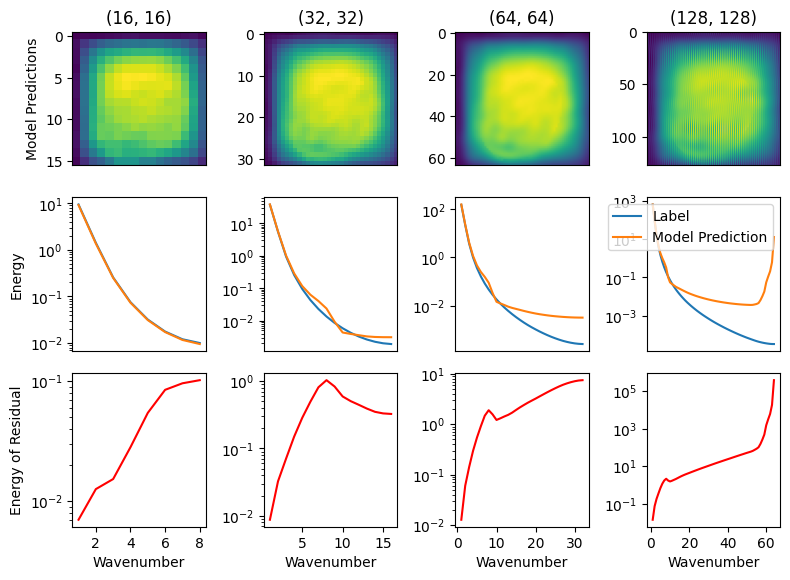

In [22]:
fig, axs = plt.subplots(3, 4, figsize=(8, 6))


# get data args
loss = 'mse'
dataset_name = 'darcy_pdebench'
darcy_forcing_term = 1.0
burger_viscosity = 'na'
(
    model_name,
    in_channels,
    out_channels,
    initial_steps,
    loss,
    batch_size,
    lr,
    wd,
    pinn_loss_weight,
) = get_dataset_info(dataset_name, loss)
max_mode = 8
# grab trained model
model = get_model(
    model_name=model_name,
    max_modes=max_mode,
    hidden_channels=32,
    in_channels=in_channels,
    out_channels=out_channels,
)

#ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{img_size}_{max_mode}_{model_name}_{in_channels}_{initial_steps}'
resolutions = str_from_res([0,0,0,1])
ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{resolutions}'
ckpt_dir = str(ckpt_dir).replace('.', '')
print(ckpt_dir)
ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
ckpt_dict = load_latest_ckpt(ckpt_pth)
model.load_state_dict(ckpt_dict['model_state_dict'])
model = model.to(device)
model = model.eval()

for x_idx, res in enumerate([16, 32, 64, 128]):
    resolution_ratio = [0, 0, 0, 0]
    resolution_ratio[-(x_idx+1)] = 1
    resolutions = [16, 32, 64, 128]# [128, 64, 32, 16]
    dataset = get_dataset(
        dataset_name=dataset_name,
        filter_lim=-1,
        img_size=res,
        downsample_dim=-1,
        train=False,
        initial_steps=initial_steps,
        model_name=model_name,
        darcy_forcing_term=darcy_forcing_term,
        burger_viscosity=burger_viscosity,
        batch_size=128,
        seed=0,
        resolution_ratios=resolution_ratio,
    )
    # sample = dataset[0]
    sample = {
        'x': torch.concat([dataset[i]['x'] for i in range(len(dataset))]),
        'y': torch.concat([dataset[i]['y'] for i in range(len(dataset))]),
    }
    # grab a single input from the last batch
    model_input = sample['x'].to(device)  # .unsqueeze(dim=0).to(device)
    with torch.no_grad():
        model_output = model(x=model_input)
    ground_truth = sample['y']  # .unsqueeze(dim=0)
    residuals = model_output - ground_truth.to(
        device
    )  # / ground_truth.to(device)

    # convert to plotable form
    model_in = model_input[0, 0, :, :].cpu().numpy()
    output = model_output[0, 0, :, :].cpu().numpy()
    label = ground_truth[0, 0, :, :].cpu().numpy()

    axs[0, x_idx].imshow(output)
    #axs[3, x_idx].imshow(output-label)
    axs[0, x_idx].set_title(f'{(resolutions[x_idx], resolutions[x_idx])}')
    # axs[0, x_idx].get_yaxis().set_visible(False)
    axs[0, x_idx].get_xaxis().set_visible(False)
    axs[1, x_idx].get_xaxis().set_visible(False)

    label_spectrum = get_energy_curve(ground_truth)
    pred_spectrum = get_energy_curve(model_output)
    residual_spectrum = get_energy_curve(residuals)

    axs[1, x_idx].set_yscale('log')
    x = np.linspace(1, len(label_spectrum), len(label_spectrum))
    axs[1, x_idx].plot(x, label_spectrum, label='Label')
    axs[1, x_idx].plot(x, pred_spectrum, label='Model Prediction')

    axs[2, x_idx].set_yscale('log')
    axs[2, x_idx].plot(
        x, residual_spectrum / label_spectrum, label='Resid', color='red'
    )
    axs[2, x_idx].set_xlabel('Wavenumber')
    # plt.locator_params(axis="x", integer=True, tight=True)
    axs[2, x_idx].xaxis.set_major_locator(
        ticker.MaxNLocator(integer=True, nbins=4)
    )
    if x_idx == 0:
        axs[2, x_idx].set_ylabel('Energy of Residual')
        axs[1, x_idx].set_ylabel('Energy')
        axs[0, x_idx].set_ylabel('Model Predictions')
        #axs[3, x_idx].set_ylabel('Residual')

axs[1, x_idx].legend(loc='upper right')
plt.tight_layout()
fig.savefig(
    f'{FIG_DIR}/aliasing_overview.pdf',  # .png
    dpi=300,
    bbox_inches='tight',
)

0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_8_FNO2D_1_1_05_1_single_0_0_0_1
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_8_FNO2D_1_1_05_1_single_0_0_0_1/150_ckpt.pth
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000


/tmp/ipykernel_1691912/1970323795.py:119: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


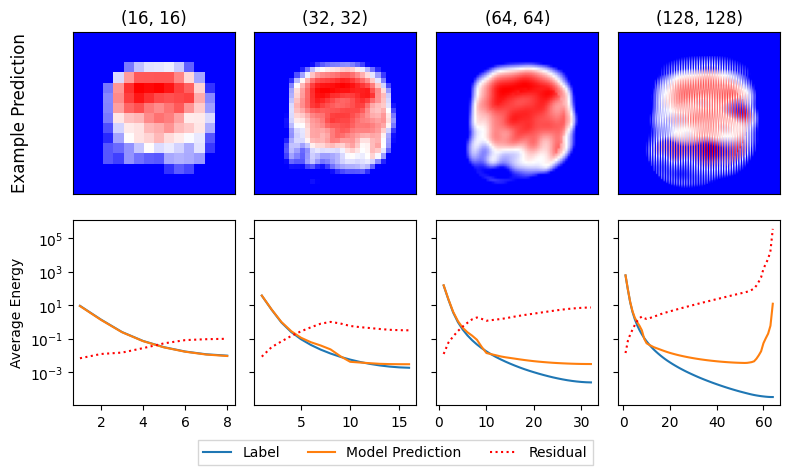

In [87]:
#fig, axs = plt.subplots(3, 4, figsize=(8, 8))

fig = plt.figure(layout='constrained', figsize=(8, 4))
subfigs = fig.subfigures(2, 1, wspace=0.07) # three rows

img_axs = subfigs[0].subplots(1, 4, sharey=False)
spectrum_axs = subfigs[1].subplots(1, 4, sharey='row')
#residual_axs = subfigs[2].subplots(1, 4, sharey='row')

# get data args
loss = 'mse'
dataset_name = 'darcy_pdebench'
darcy_forcing_term = 1.0
burger_viscosity = 'na'
(
    model_name,
    in_channels,
    out_channels,
    initial_steps,
    loss,
    batch_size,
    lr,
    wd,
    pinn_loss_weight,
) = get_dataset_info(dataset_name, loss)
max_mode = 8
# grab trained model
model = get_model(
    model_name=model_name,
    max_modes=max_mode,
    hidden_channels=32,
    in_channels=in_channels,
    out_channels=out_channels,
)

#ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{img_size}_{max_mode}_{model_name}_{in_channels}_{initial_steps}'
resolutions = str_from_res([0,0,0,1])
ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{resolutions}'
ckpt_dir = str(ckpt_dir).replace('.', '')
print(ckpt_dir)
ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
ckpt_dict = load_latest_ckpt(ckpt_pth)
model.load_state_dict(ckpt_dict['model_state_dict'])
model = model.to(device)
model = model.eval()

for x_idx, res in enumerate([16, 32, 64, 128]):
    resolution_ratio = [0, 0, 0, 0]
    resolution_ratio[-(x_idx+1)] = 1
    resolutions = [16, 32, 64, 128]# [128, 64, 32, 16]
    dataset = get_dataset(
        dataset_name=dataset_name,
        filter_lim=-1,
        img_size=res,
        downsample_dim=-1,
        train=False,
        initial_steps=initial_steps,
        model_name=model_name,
        darcy_forcing_term=darcy_forcing_term,
        burger_viscosity=burger_viscosity,
        batch_size=128,
        seed=0,
        resolution_ratios=resolution_ratio,
    )
    # sample = dataset[0]
    sample = {
        'x': torch.concat([dataset[i]['x'] for i in range(len(dataset))]),
        'y': torch.concat([dataset[i]['y'] for i in range(len(dataset))]),
    }
    # grab a single input from the last batch
    model_input = sample['x'].to(device)  # .unsqueeze(dim=0).to(device)
    with torch.no_grad():
        model_output = model(x=model_input)
    ground_truth = sample['y']  # .unsqueeze(dim=0)
    residuals = model_output - ground_truth.to(
        device
    )  # / ground_truth.to(device)

    # convert to plotable form
    model_in = model_input[0, 0, :, :].cpu().numpy()
    output = model_output[0, 0, :, :].cpu().numpy()
    label = ground_truth[0, 0, :, :].cpu().numpy()

    # get spectrums
    label_spectrum = get_energy_curve(ground_truth)
    pred_spectrum = get_energy_curve(model_output)
    residual_spectrum = get_energy_curve(residuals)

    img = output #- label
    norm = colors.LogNorm(img.mean() + 0.5 * img.std(), img.max(), clip='True')
    img_axs[x_idx].imshow(img, norm=norm, cmap='bwr')
    img_axs[x_idx].set_title(f'{(resolutions[x_idx], resolutions[x_idx])}')
    img_axs[x_idx].get_yaxis().set_visible(False)
    img_axs[x_idx].get_xaxis().set_visible(False)
    subfigs[0].supylabel("Example Prediction")
    #img_axs[x_idx].set_ylabel('Model Predictions')

    spectrum_axs[x_idx].set_yscale('log')
    x = np.linspace(1, len(label_spectrum), len(label_spectrum))
    spectrum_axs[x_idx].plot(x, label_spectrum, label='Label')
    spectrum_axs[x_idx].plot(x, pred_spectrum, label='Model Prediction')
    spectrum_axs[x_idx].plot(x, residual_spectrum / label_spectrum, linestyle=":", label='Residual', color='red')
    spectrum_axs[0].set_ylabel('Average Energy')
    spectrum_axs[x_idx].xaxis.set_major_locator(
        ticker.MaxNLocator(integer=True, nbins=4)
    )
    '''
    residual_axs[x_idx].set_yscale('log')
    residual_axs[x_idx].plot(
        x, residual_spectrum / label_spectrum, label='Resid', color='red'
    )
    residual_axs[x_idx].set_xlabel('Wavenumber')
    residual_axs[0].set_ylabel('Energy of Residual')
    '''

handles, labels = spectrum_axs[x_idx].get_legend_handles_labels()
fig.legend(handles = handles , labels=labels,loc='upper center',
             bbox_to_anchor=(0.5, -0.05),fancybox=False, shadow=False, ncol=9)
plt.tight_layout()
fig.savefig(
    f'{FIG_DIR}/aliasing_overview.pdf',  # .png
    dpi=300,
    bbox_inches='tight',
)

In [ ]:
# Average Error Spectrum (Figure 2)

# grab trained model
loss = 'mse'
dataset_name = 'darcy_pdebench'
darcy_forcing_term = 1.0
burger_viscosity = 'na'
seed = 0
(
    model_name,
    in_channels,
    out_channels,
    initial_steps,
    loss,
    batch_size,
    lr,
    wd,
    pinn_loss_weight,
) = get_dataset_info(dataset_name, loss)
max_mode = 8
model = get_model(
    model_name=model_name,
    max_modes=max_mode,
    hidden_channels=32,
    in_channels=in_channels,
    out_channels=out_channels,
)
resolutions = str_from_res([0,0,0,1])
ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{resolutions}'
ckpt_dir = str(ckpt_dir).replace('.', '')
ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
ckpt_dict = load_latest_ckpt(ckpt_pth)
model.load_state_dict(ckpt_dict['model_state_dict'])
model = model.to(device)
model = model.eval()

fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey='row')
train_loader, test_loaders = get_data(
    dataset_name=dataset_name,
    filter_lim=filter_lim,
    img_size=s,
    downsample_dim=downsample_dim,
    train=False,
    initial_steps=initial_steps,
    model_name=model_name,
    darcy_forcing_term=darcy_forcing_term,
    burger_viscosity=burger_viscosity,
    seed=seed,
    batch_size=batch_size,
    resolution_ratios=resolution_ratio,
    test_res = "multi",
)
for idx, s in enumerate([128, 64, 32, 16]):

    test_loader = test_loaders[f'test_res_{idx}']
    dataset = test_loader.dataset
    # squeeze the dataset to remove the empty channel dimension
    model_preds_test = get_model_preds(test_loader, model, device, initial_steps).squeeze()
    shape = model_preds_test.shape
    sample = {
        #'x': torch.concat([dataset[i]['x'] for i in range(len(dataset))]),
        'y': torch.concat([dataset[i]['y'] for i in range(len(dataset))]),
    }

    ground_truth = sample['y']
    residuals = model_preds_test.to('cpu') - ground_truth

    test_sp_y = get_energy_curve(ground_truth,  s)

    residual_spectrum = get_energy_curve(residuals, s )

    # Configure pyplot and generate the plot
    ax.set_yscale('log')
    x = np.linspace(1, s // 2, s // 2)
    ax.plot(
        # abs(test_sp_model_pred - test_sp_y) / test_sp_y,
        x,
        residual_spectrum / test_sp_y,
        linestyle='-',
        label=f'Res {s}',
    )
    ax.axvline(x=8, color='grey', linestyle='--')

    fig.suptitle(f'{dataset_name} Dataset')

fig.supxlabel('Wavenumber')
fig.supylabel('Energy of Residual \n (Pred - Label)')

# show the figure
leg = plt.legend(loc='best')
leg.get_frame().set_alpha(0.5)
plt.tight_layout()
plt.show()
fig.savefig(
    f'{FIG_DIR}/higher_res_residual_spectrum.pdf',  # .png
    dpi=300,
    bbox_inches='tight',
)

Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_8_FNO2D_1_1_05_1_single_0_0_0_1/150_ckpt.pth
resolution_ratios=[0, 0, 0, 1]
self.num_samples=9000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000


# Show the turbulence (power spectra of all our datasets)

TODO
- Do this w/ error bars for the time-varying data
- Add additional power spectra for varying NS (compressible settings)

NOTE: for compressible NS, I am just showing the spectrum of a single field (X Velocity)

2d energy
dataset_name='darcy_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
1d energy
dataset_name='burgers_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
loaded force curl self.force_curl.shape=(109, 510, 510)
loaded vorticity self.vorticity.shape=(109, 20, 510, 510)
loaded Vx self.vx.shape=(109, 20, 510, 510)
loaded Vy self.vy.shape=(109, 20, 510, 510)
loaded force curl self.force_curl.shape=(0, 255, 255)
loaded vorticity self.vorticity.shape=(0, 20, 255, 255)
loaded Vx self.vx.shape=(0, 20, 255, 255)
loaded Vy self.vy.shape=(0, 20, 255, 255)
loaded force curl self.force_curl.shape=(0, 85, 85)
loaded vorticity self.vorticity.shape=(0, 20, 85, 85)
loaded Vx self.vx.shape=(0, 20, 85, 85)
loaded Vy self.vy.shape=(0, 20, 85, 85)
loaded force curl self.force_curl.shape=(0, 17, 17)
loaded vorticity self.vorticity.shape=(0, 20, 17, 17)
loaded Vx self.vx.shape=(0, 

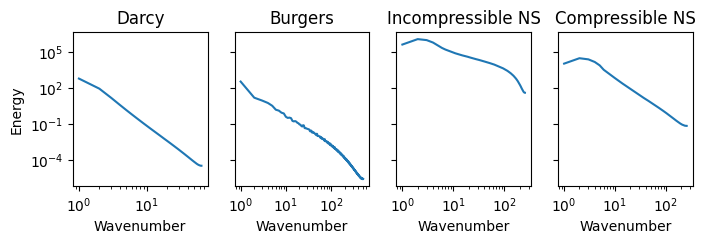

In [4]:
fig, axs = plt.subplots(1, 4, sharey='row', figsize=(8, 2))

for x_idx, dataset_name in enumerate(
    ['darcy_pdebench', 'burgers_pdebench', 'incomp_ns_pdebench', 'ns_pdebench']
):
    if 'burgers' in dataset_name:
        print('1d energy')
        energy_curve_func = get_energy_curve_1d
    else:
        print('2d energy')
        energy_curve_func = get_energy_curve

    print(f'{dataset_name=}')
    img_size = 510
    title = 'Incompressible NS'

    if dataset_name == 'ns_pdebench':
        img_size = 512
        title = 'Compressible NS'

    if dataset_name == 'darcy_pdebench':
        img_size = 128
        title = 'Darcy'

    if dataset_name == 'burgers_pdebench':
        img_size = 1024
        title = 'Burgers'
    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        _,
        _,
        _,
    ) = get_dataset_info(dataset_name, "mse")

    darcy_forcing_term = 1.0
    burger_viscosity = 0.001
    comp_ns_params = ['Turb', 1.0, 1e-08, 1e-08, 'periodic', 512]
    seed = 0     

    dataset = get_dataset(
        dataset_name=dataset_name,
        filter_lim=-1,
        img_size='na',
        downsample_dim=-1,
        train=False,
        initial_steps=initial_steps,
        model_name=model_name,
        darcy_forcing_term=darcy_forcing_term,
        burger_viscosity=burger_viscosity,
        batch_size=128,
        seed=0,
        resolution_ratios=[1, 0, 0, 0],
        comp_ns_params=comp_ns_params,
    )
    labels = torch.concat([dataset[i]['y'] for i in range(len(dataset))])
    if dataset_name == 'ns_pdebench':
        labels = labels[
            :, :, 2, ...
        ]  # choose specific channel [density, pressure, X Vel, Y Vel]
    label_spectrum = energy_curve_func(labels)

    x = np.linspace(1, len(label_spectrum), len(label_spectrum))
    axs[x_idx].plot(x, label_spectrum)
    axs[x_idx].set_yscale('log')
    axs[x_idx].set_xscale('log')
    axs[x_idx].set_title(title)
    axs[x_idx].set_xlabel('Wavenumber')
    if x_idx == 0:
        axs[x_idx].set_ylabel('Energy')

2d energy
dataset_name='ns_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
loaded density, density.shape=(1000, 21, 128, 128)
loaded pressure
loaded Vx
loaded Vy
loaded density, density.shape=(0, 21, 64, 64)
loaded pressure
loaded Vx
loaded Vy
loaded density, density.shape=(0, 21, 32, 32)
loaded pressure
loaded Vx
loaded Vy
loaded density, density.shape=(0, 21, 16, 16)
loaded pressure
loaded Vx
loaded Vy
2d energy
dataset_name='ns_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
loaded density, density.shape=(1000, 21, 128, 128)
loaded pressure
loaded Vx
loaded Vy
loaded density, density.shape=(0, 21, 64, 64)
loaded pressure
loaded Vx
loaded Vy
loaded density, density.shape=(0, 21, 32, 32)
loaded pressure
loaded Vx
loaded Vy
loaded density, density.shape=(0, 21, 16, 16)
loaded pressure
loaded Vx
loaded Vy


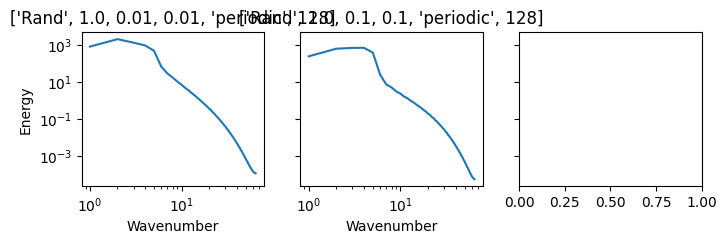

In [13]:
# compare the many compressible NS methods
fig, axs = plt.subplots(1, 3, sharey='row', figsize=(8, 2))

for x_idx, comp_ns_params in enumerate(
    [
        # ['Rand', 1.0, 1e-08, 1e-08, 'periodic', 512],
        ['Rand', 1.0, 1e-02, 1e-02, 'periodic', 128],
        ['Rand', 1.0, 1e-01, 1e-01, 'periodic', 128],
    ]
):
    for dataset_name in ['ns_pdebench']:
        if 'burgers' in dataset_name:
            print('1d energy')
            energy_curve_func = get_energy_curve_1d
        else:
            print('2d energy')
            energy_curve_func = get_energy_curve

        print(f'{dataset_name=}')
        batch_size = 128
        batch_size = 128
        in_channels = 10
        out_channels = 1
        initial_steps = 10
        filter_lim = -1
        downsample_dim = -1

        model_name = 'FNO2D'
        darcy_forcing_term = 1.0
        burger_viscosity = 0.001
        seed = 0

        if dataset_name == 'ns_pdebench':
            batch_size = 4
            in_channels = 40
            out_channels = 4
            title = 'Compressible NS'

        dataset = get_dataset(
            dataset_name=dataset_name,
            filter_lim=filter_lim,
            img_size='na',
            downsample_dim=downsample_dim,
            train=False,
            initial_steps=initial_steps,
            model_name=model_name,
            darcy_forcing_term=darcy_forcing_term,
            burger_viscosity=burger_viscosity,
            batch_size=128,
            seed=0,
            resolution_ratios=[1, 0, 0, 0],
            comp_ns_params=comp_ns_params,
        )
        labels = torch.concat([dataset[i]['y'] for i in range(len(dataset))])
        if dataset_name == 'ns_pdebench':
            labels = labels[
                :, :, 2, ...
            ]  # choose specific channel [density, pressure, X Vel, Y Vel]
        label_spectrum = energy_curve_func(labels)

        x = np.linspace(1, len(label_spectrum), len(label_spectrum))
        axs[x_idx].plot(x, label_spectrum)
        axs[x_idx].set_yscale('log')
        axs[x_idx].set_xscale('log')
        axs[x_idx].set_title(comp_ns_params)
        axs[x_idx].set_xlabel('Wavenumber')
        if x_idx == 0:
            axs[x_idx].set_ylabel('Energy')

## Visualize Burgers + Incomp NS

Looking for turbulence: vis + energy spectrum

TODO: https://github.com/pdebench/PDEBench/blob/main/pdebench/data_download/visualize_pdes.py#L168

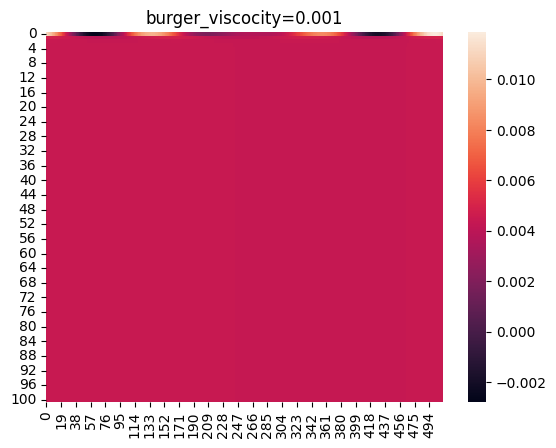

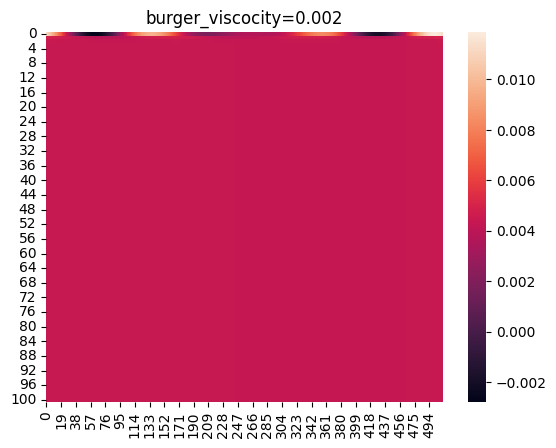

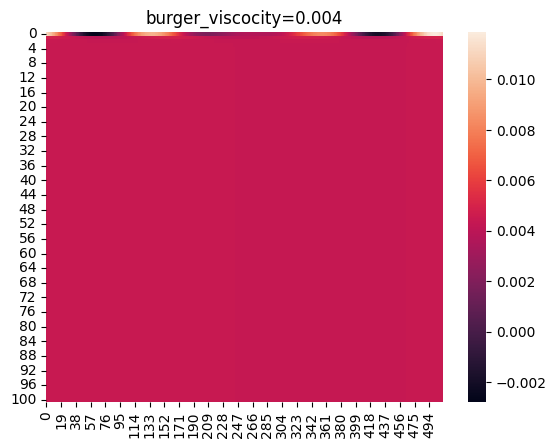

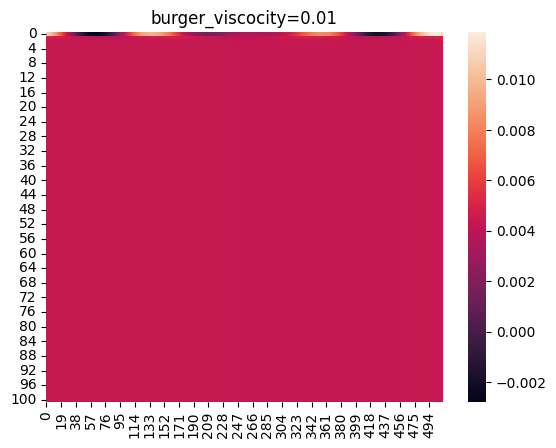

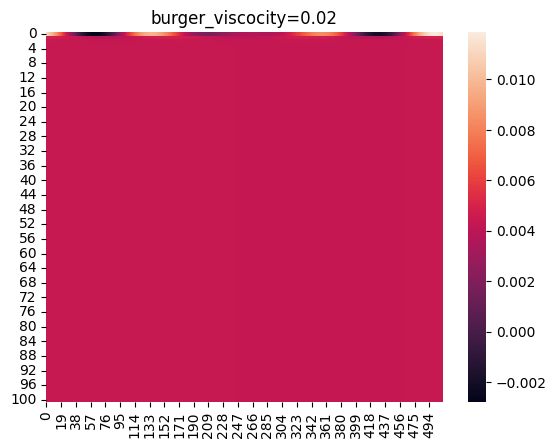

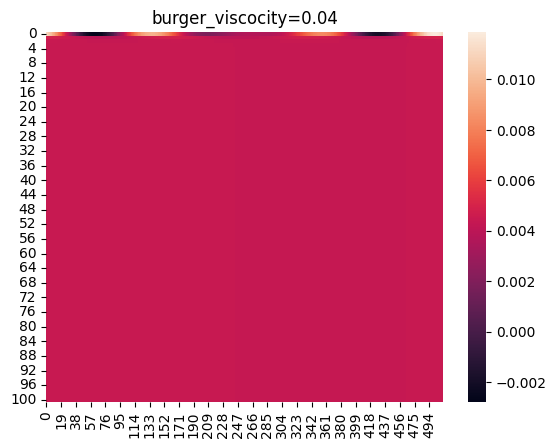

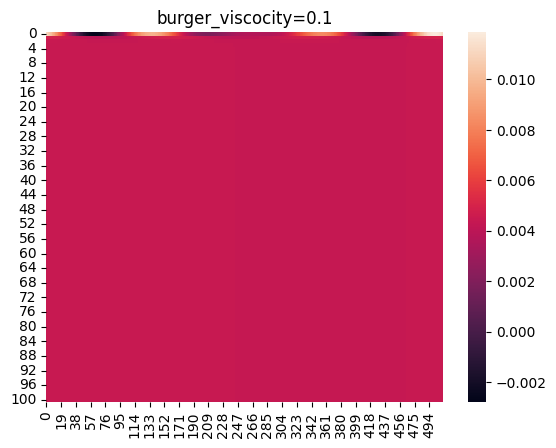

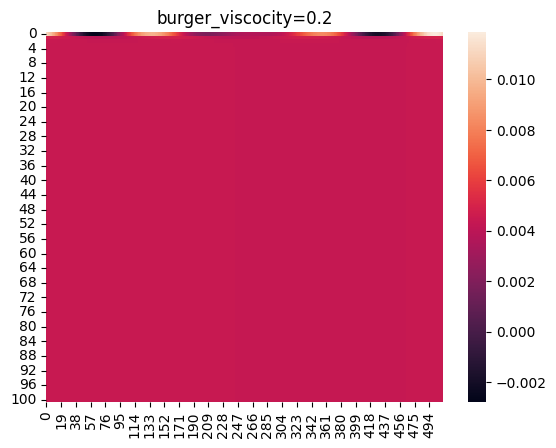

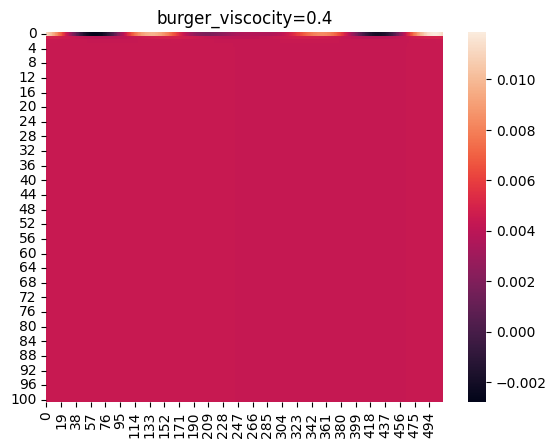

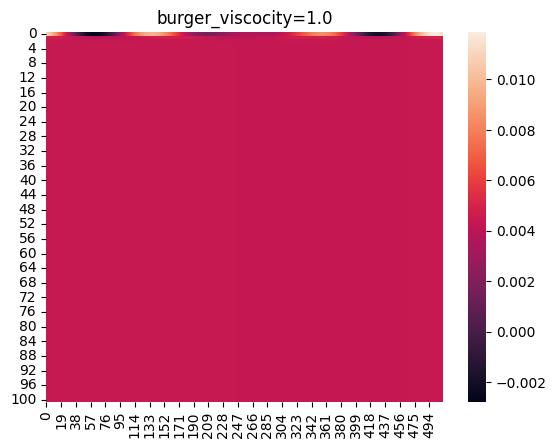

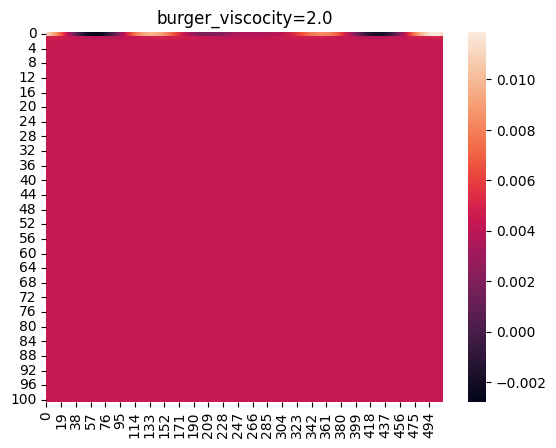

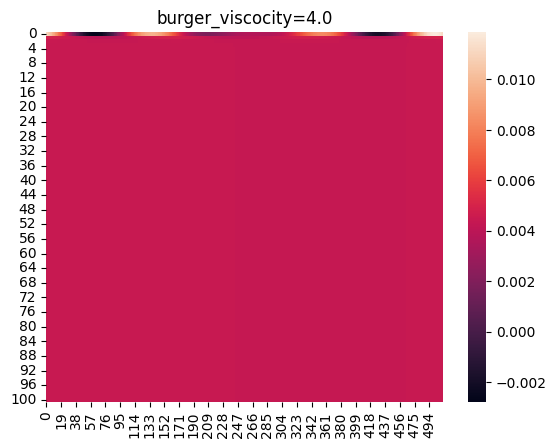

In [46]:
# vis burgers at different visocity coeffs

dataset_name = 'burgers_pdebench'
img_size = 512
max_mode = img_size // 2
in_channels = 1
out_channels = 1
initial_steps = 1
filter_lim = -1
downsample_dim = -1
model_name = 'FNO2D'
darcy_forcing_term = 1.0
burger_viscosity = 1.0

for burger_viscocity in [
    0.001,
    0.002,
    0.004,
    0.01,
    0.02,
    0.04,
    0.1,
    0.2,
    0.4,
    1.0,
    2.0,
    4.0,
]:
    dataset = get_dataset(
        dataset_name=dataset_name,
        filter_lim=filter_lim,
        img_size=img_size,
        downsample_dim=downsample_dim,
        train=False,
        initial_steps=initial_steps,
        model_name=model_name,
        darcy_forcing_term=darcy_forcing_term,
        burger_viscosity=burger_viscosity,
    )
    x = dataset[100]['y'].squeeze()
    norm1 = x / np.linalg.norm(x)
    # plt.imshow(norm1)
    # plt.colorbar(orientation='horizontal')
    sns.heatmap(norm1)

    plt.title(f'{burger_viscocity=}')
    plt.show()

# HP Search

Find optimial HP config for darcy, burgers, and incompressible navier stokes, and compressible navier stokes

TODO: select best models!

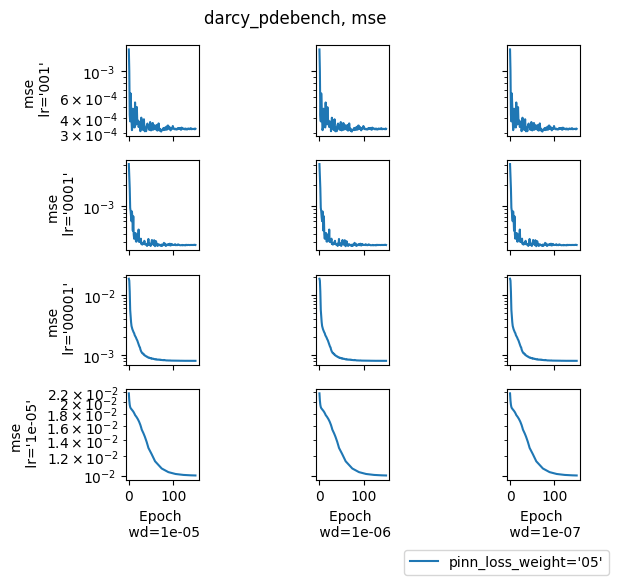

/tmp/ipykernel_416808/968738691.py:95: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


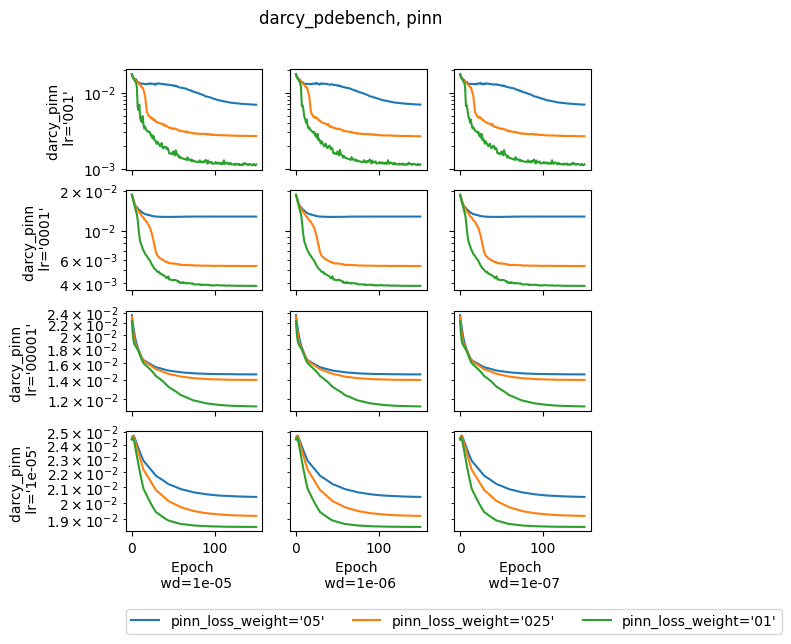

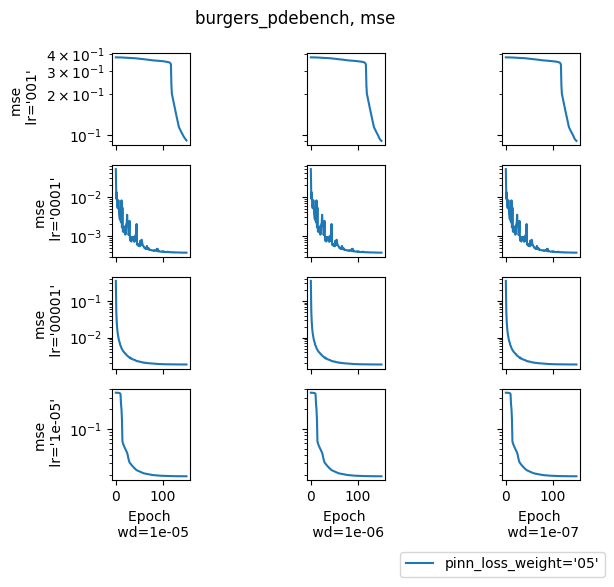

/tmp/ipykernel_416808/968738691.py:95: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


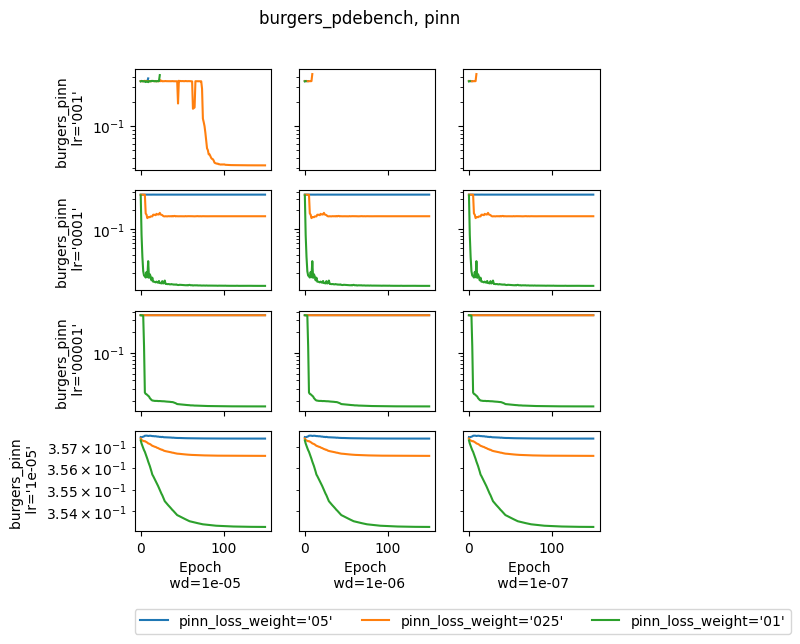

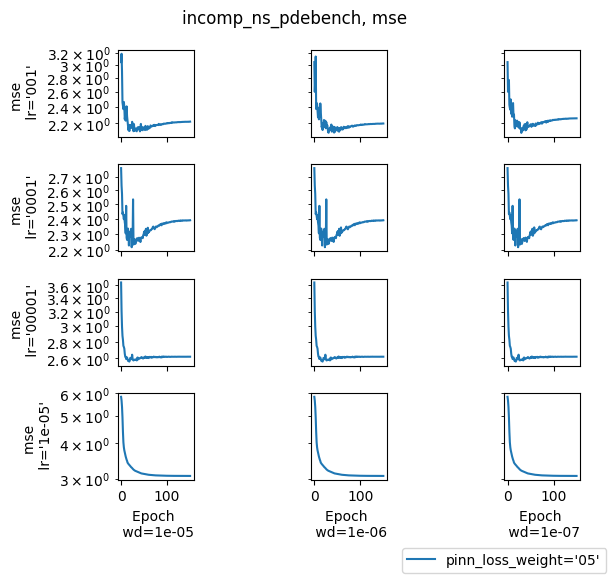

/tmp/ipykernel_416808/968738691.py:95: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


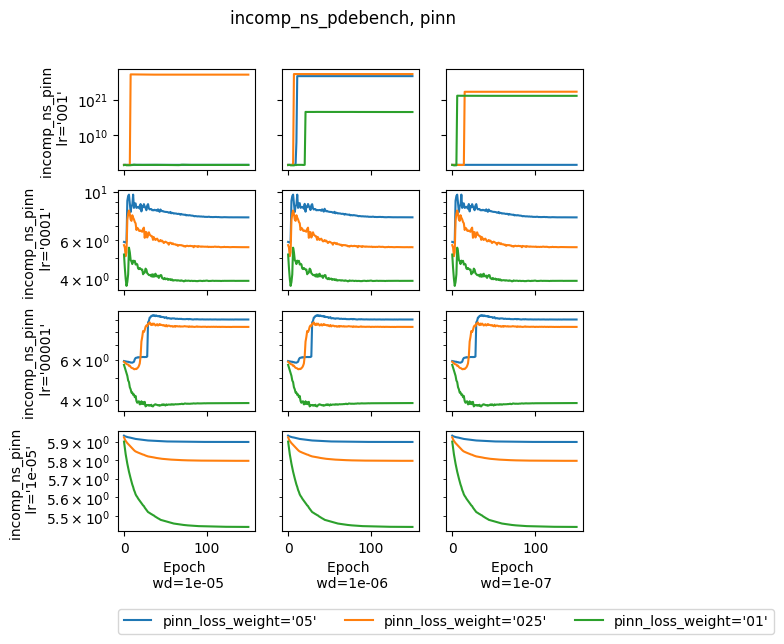

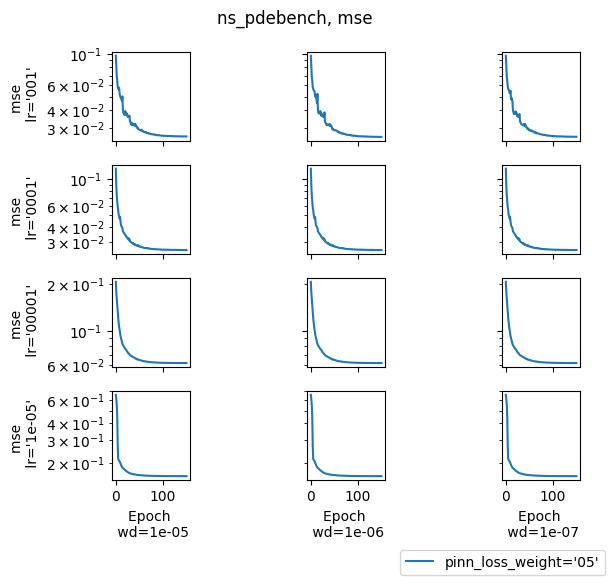

finished_exp=156, total_exp=156, 100.0 %


In [5]:
# Check if all experiments have finished
total_exp = 0
finished_exp = 0
learning_rates = {'001': 1e-2, '0001': 1e-3, '00001': 1e-4, '1e-05': 1e-5}
pinn_weights = {'05': 0.5, '025': 0.25, '01': 0.1}
summary_stats = pd.DataFrame(
    columns=['data', 'loss', 'lr', 'wd', 'pinn_loss_weight', 'test']
)
for dataset_name in [
    'darcy_pdebench',
    'burgers_pdebench',
    'incomp_ns_pdebench',
    'ns_pdebench',
]:
    img_size = 255

    if dataset_name == 'ns_pdebench':
        img_size = 256

    if dataset_name == 'darcy_pdebench':
        img_size = 64

    if dataset_name == 'burgers_pdebench':
        img_size = 512

    for loss_type in ['mse', 'pinn']:
        (
            model_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            _,
            _,
            _,
        ) = get_dataset_info(dataset_name, loss_type)
        if loss == 'n/a':
            continue
        fig, axes = plt.subplots(
            nrows=4, ncols=3, sharey='row', sharex='col', figsize=(6, 6)
        )
        for y_idx, lr in enumerate(['001', '0001', '00001', '1e-05']):
            for x_idx, wd in enumerate([1e-05, 1e-06, 1e-07]):
                pinn_loss_weights = ['05']
                if 'pinn' in loss_type:
                    pinn_loss_weights += ['025', '01']
                for pinn_loss_weight in pinn_loss_weights:
                    max_mode = img_size // 2
                    resolutions = str_from_res([0, 1, 0, 0])
                    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{resolutions}'
                    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                    ckpt_name = f'{ckpt_pth}/train_stats.csv'
                    total_exp += 1
                    if not os.path.exists(ckpt_name):
                        print('does not exist: ', ckpt_dir)
                        continue
                    # print(ckpt_dir)
                    df = pd.read_csv(ckpt_name)
                    for ylabel in [
                        #'train_loss',
                        'test',
                    ]:
                        if 150 in df['epoch']:
                            finished_exp += 1
                            row = df[df.epoch == 150]
                            summary_stats.loc[len(summary_stats)] = [
                                dataset_name,
                                loss,
                                learning_rates[lr],
                                wd,
                                pinn_weights[pinn_loss_weight],
                                row[ylabel].item(),
                            ]
                        else:
                            print('Not finished: ', ckpt_name)
                        sns.lineplot(
                            df,
                            x='epoch',
                            y=ylabel,
                            label=f'{pinn_loss_weight=}',
                            ax=axes[y_idx, x_idx],
                        )
                        axes[y_idx, x_idx].get_legend().remove()
                        axes[y_idx, x_idx].set_yscale('log')

                if y_idx == 3:
                    axes[y_idx, x_idx].set_xlabel(f'Epoch \n {wd=}')
                if x_idx == 0:
                    axes[y_idx, x_idx].set_ylabel(f'{loss} \n {lr=}')

        plt.legend(bbox_to_anchor=(0, -0.7), loc='upper center', ncols=3)

        fig.suptitle(f'{dataset_name}, {loss_type}')
        plt.tight_layout()
        plt.show()
print(f'{finished_exp=}, {total_exp=}, {finished_exp / total_exp * 100} %')

In [3]:
best_hps = summary_stats.loc[
    summary_stats.groupby(['data', 'loss']).test.idxmin()
]
best_hps

,data,loss,lr,wd,pinn_loss_weight,test
66,burgers_pdebench,burgers_pinn,0.0010,1.000000e-05,0.1,0.012701
46,burgers_pdebench,mse,0.0010,1.000000e-05,0.5,0.000381
9,darcy_pdebench,darcy_pinn,0.0100,1.000000e-05,0.1,0.001141
0,darcy_pdebench,mse,0.0010,1.000000e-07,0.5,0.000274
123,incomp_ns_pdebench,incomp_ns_pinn,0.0001,1.000000e-05,0.1,3.866482
92,incomp_ns_pdebench,mse,0.0100,1.000000e-06,0.5,2.194969
143,ns_pdebench,mse,0.0010,1.000000e-06,0.5,0.025513


# PINNs

TODO:
- make fig about pinn's weights
- make fig w/ ns various feilds

2d energy
dataset_name='darcy_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000


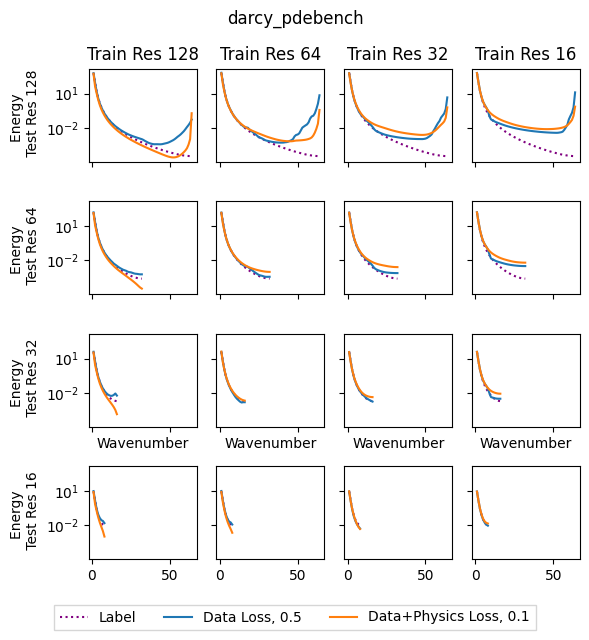

1d energy
dataset_name='burgers_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000


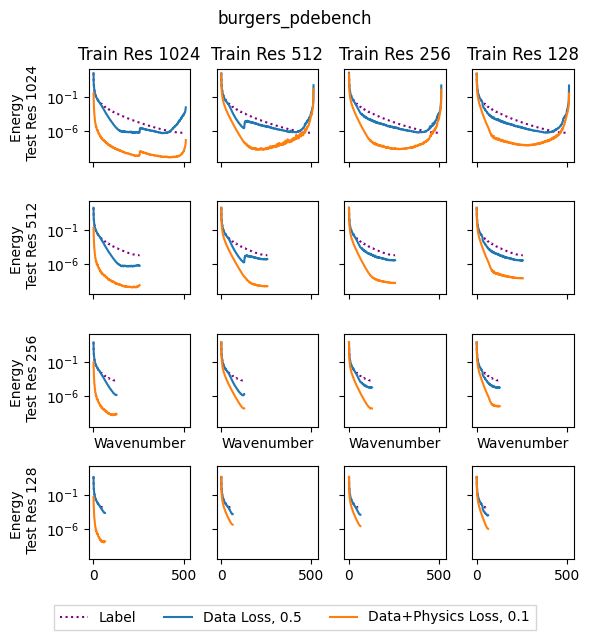

2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[0, 1, 0, 0]
self.num_samples=109
resolution_ratios=[0, 0, 1, 0]
self.num_samples=109


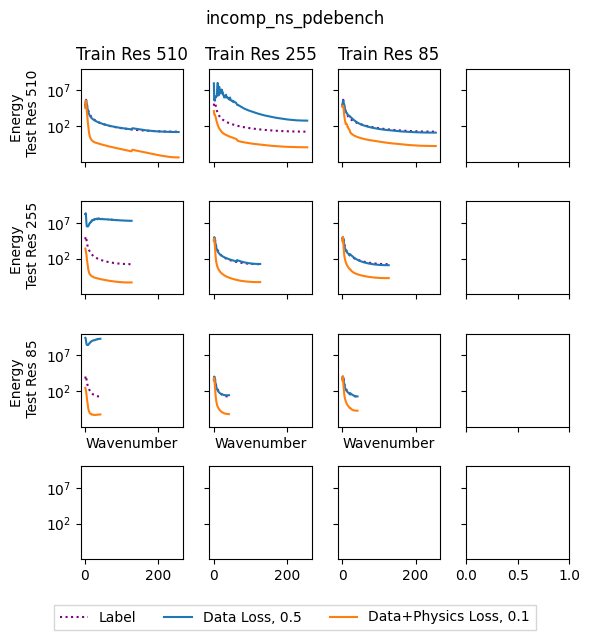

finished_exp=82, total_exp=82, 100.0 %


In [2]:
colors = ['red', 'green', 'blue', 'purple', 'brown', 'orange', 'pink']
total_exp = 0
finished_exp = 0
for dataset_name in [
    #'ns_pdebench',
    'darcy_pdebench',
    'burgers_pdebench',
    'incomp_ns_pdebench',
]:
    if 'burgers' in dataset_name:
        print('1d energy')
        energy_curve_func = get_energy_curve_1d
    else:
        print('2d energy')
        energy_curve_func = get_energy_curve

    print(f'{dataset_name=}')
    # if dataset_name == 'incomp_ns_pdebench':
    
    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        _,
        _,
        _,
    ) = get_dataset_info(dataset_name, "mse")
    img_sizes = [510, 255, 85]
    if dataset_name == 'ns_pdebench':
        img_sizes = [512, 256, 128, 64]
        
    if dataset_name == 'darcy_pdebench':
        img_sizes = [128, 64, 32, 16]

    if dataset_name == 'burgers_pdebench':
        img_sizes = [1024, 512, 256, 128]

    for epoch in [150]:  # 0, 50, 100, 250, 500
        fig, axes = plt.subplots(
            nrows=4, ncols=4, sharey=True, sharex='col', figsize=(6, 6)
        )
        for y_idx, test_size in enumerate(range(len(img_sizes))):
            # get data
            test_resolutions = [0, 0, 0, 0]
            test_resolutions[test_size] = 1
            dataset = get_dataset(
                dataset_name=dataset_name,
                filter_lim=-1,
                img_size=test_size,
                downsample_dim=-1,
                train=False,
                initial_steps=initial_steps,
                model_name=model_name,
                darcy_forcing_term=darcy_forcing_term,
                burger_viscosity=burger_viscosity,
                batch_size=batch_size,
                seed=0,
                resolution_ratios=test_resolutions,
                comp_ns_params=comp_ns_params, 
            )
            test_loader = DataLoader(dataset, batch_size=1)

            for x_idx, img_size in enumerate(range(len(img_sizes))):
                if y_idx == 2:
                    axes[y_idx, x_idx].set_xlabel('Wavenumber')
                if y_idx == 0:
                    axes[y_idx, x_idx].set_title(
                        f'Train Res {img_sizes[img_size]}'
                    )
                if x_idx == 0:
                    axes[y_idx, x_idx].set_ylabel(
                        f'Energy \n Test Res {img_sizes[test_size]}'
                    )

                train_resolutions = [0, 0, 0, 0]
                train_resolutions[img_size] = 1
                train_resolutions = ''.join(str(train_resolutions).split())
                offset = 0
                if initial_steps == 1:
                    offset = 1
                label_spectrum = energy_curve_func(
                    torch.concat(
                        [
                            test_loader.dataset[i]['y'][:, initial_steps - offset:, ...]
                            for i in range(len(test_loader))
                        ]
                    )
                )

                x = np.linspace(1, len(label_spectrum), len(label_spectrum))
                axes[y_idx, x_idx].plot(
                    x,
                    label_spectrum,
                    label='Label',
                    color='purple',
                    linestyle=':',
                )
                for _y_idx, loss in enumerate(['mse', 'pinn']):
                    
                    (
                        model_name,
                        in_channels,
                        out_channels,
                        initial_steps,
                        loss,
                        batch_size,
                        lr,
                        wd,
                        pinn_loss_w,
                    ) = get_dataset_info(dataset_name, loss)
                    lr = str(lr).replace('.', '')
                    pinn_loss_weights = [pinn_loss_w]
                    #if 'pinn' in loss:
                    #    pinn_loss_weights = ['05', '025', '01']
                    for pinn_loss_weight in pinn_loss_weights:
                        loss_type = 'Data Loss'
                        col = 'green'
                        if 'pinn' in loss:
                            loss_type = 'Data+Physics Loss'
                            col = 'orange'
    
                        max_mode = img_sizes[img_size] // 2
                        ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{str_from_res(train_resolutions)}'
                        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                        ckpt_pth = ckpt_pth.replace(".",'')
                        model = get_model(
                            model_name=model_name,
                            max_modes=max_mode,
                            hidden_channels=32,
                            in_channels=in_channels,
                            out_channels=out_channels,
                        )
    
                        # ckpt_dict = load_latest_ckpt(ckpt_pth)
                        ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
                        total_exp += 1
                        if not os.path.exists(ckpt_file):
                            print('waiting for experiment: ', ckpt_file)
                            continue
                        # print("FINISHED: ", ckpt_file)
                        finished_exp += 1
                        ckpt_dict = torch.load(
                            ckpt_file,
                            weights_only=False,
                        )
                        model.load_state_dict(ckpt_dict['model_state_dict'])
                        model = model.to(device)
                        model = model.eval()
    
                        # get model pred
                        model_preds_test = get_model_preds(
                            test_loader, model, device, initial_steps
                        )  # .squeeze()
    
                        model_pred_spectrum = energy_curve_func(
                            model_preds_test  # .squeeze()
                        )
    
                        axes[y_idx, x_idx].set_yscale('log')
                        axes[y_idx, x_idx].plot(
                            x,
                            model_pred_spectrum,
                            label=f'{loss_type}, {pinn_loss_weight}',
                            #color=col,
                        )
    
                        handles, labels = axes[
                            y_idx, x_idx
                        ].get_legend_handles_labels()

        fig.legend(
            handles=handles,
            labels=labels,
            loc='upper center',
            bbox_to_anchor=(0.5, -0.0),
            fancybox=False,
            shadow=False,
            ncol=4,
        )
        fig.suptitle(f'{dataset_name}')
        plt.tight_layout()
        plt.show()
        fig.savefig(
            f'{FIG_DIR}/{dataset_name}_pinn_vs_no_pinn_label_spectrums.pdf',
            bbox_inches='tight',
            dpi=300,
        )
print(f'{finished_exp=}, {total_exp=}, {finished_exp / total_exp * 100} %')

# Compound aliasing over time w/ Burgers/Incompressible NS/Compressible NS

TODO: show that aliasing gets worse over time w/ autoregressive inference

NOTE: normalizatoin causes NAN spectrums for residuals???

1d energy
dataset_name='burgers_pdebench'
waiting for experiment:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_64_burgers_pdebench_-1_-1_256_FNO1D_10_1_05_10_single_[0,1,0,0]//150_ckpt.pth
2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
loaded force curl self.force_curl.shape=(109, 510, 510)
loaded vorticity self.vorticity.shape=(109, 20, 510, 510)
loaded Vx self.vx.shape=(109, 20, 510, 510)
loaded Vy self.vy.shape=(109, 20, 510, 510)
loaded force curl self.force_curl.shape=(0, 255, 255)
loaded vorticity self.vorticity.shape=(0, 20, 255, 255)
loaded Vx self.vx.shape=(0, 20, 255, 255)
loaded Vy self.vy.shape=(0, 20, 255, 255)
loaded force curl self.force_curl.shape=(0, 85, 85)
loaded vorticity self.vorticity.shape=(0, 20, 85, 85)
loaded Vx self.vx.shape=(0, 20, 85, 85)
loaded Vy self.vy.shape=(0, 20, 85, 85)
loaded force curl self.force_curl.shape=(0, 17, 17)
loaded vorticity self.vorticity.shape=

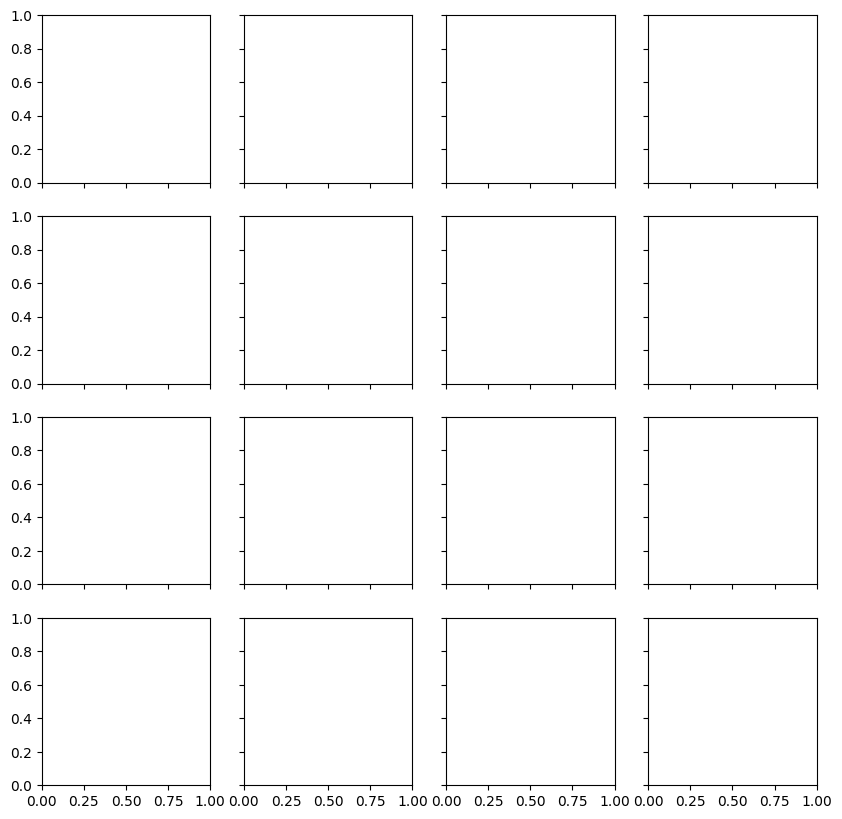

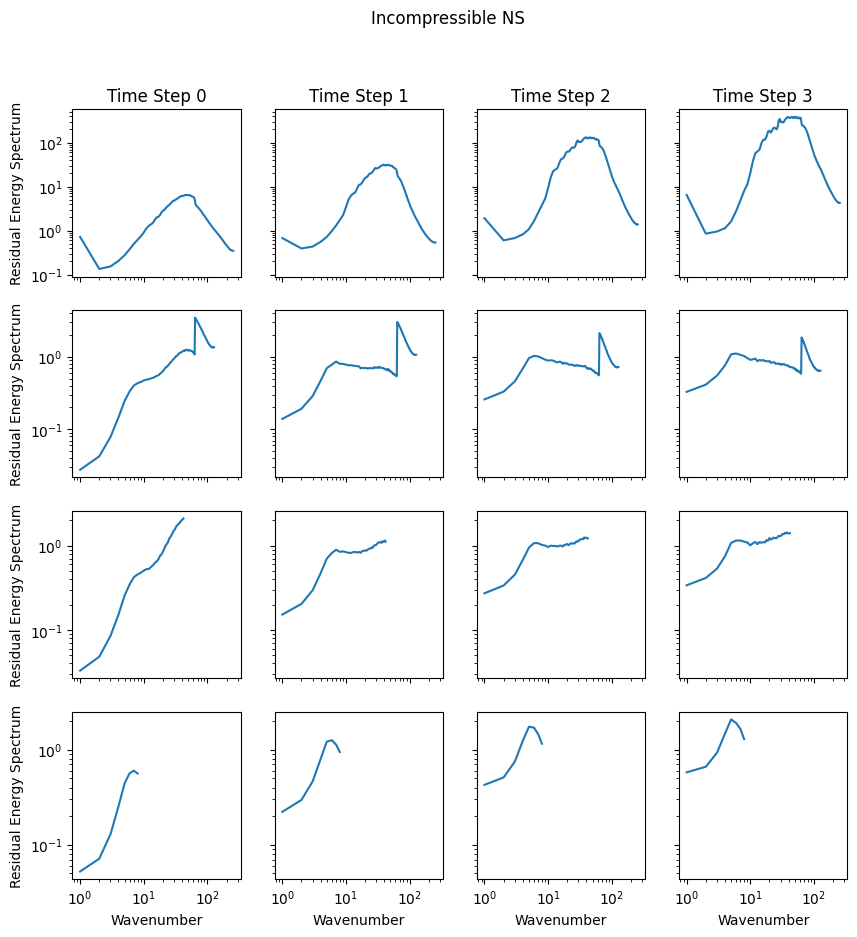

2d energy
dataset_name='ns_pdebench'
waiting for experiment:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_single_[0,1,0,0]//150_ckpt.pth


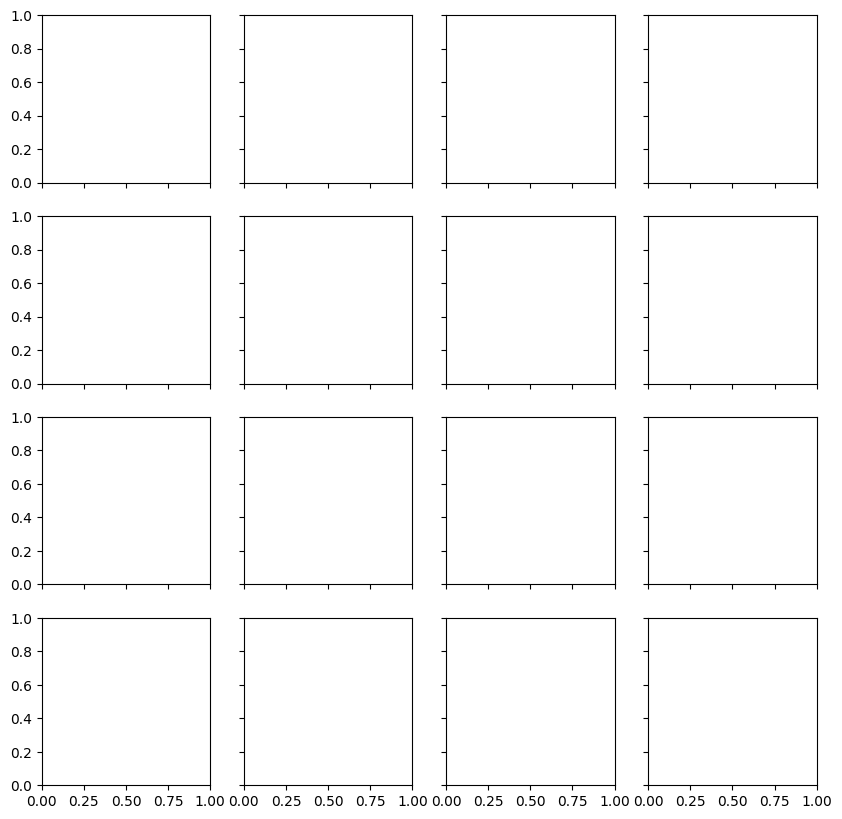

In [4]:
for dataset_name in ['burgers_pdebench', 'incomp_ns_pdebench', 'ns_pdebench']:
    fig, axs = plt.subplots(4, 4, sharey='row', sharex='col', figsize=(10, 10))
    if 'burgers' in dataset_name:
        print('1d energy')
        energy_curve_func = get_energy_curve_1d
    else:
        print('2d energy')
        energy_curve_func = get_energy_curve

    print(f'{dataset_name=}')
    batch_size = 128
    batch_size = 128
    in_channels = 10
    out_channels = 1
    initial_steps = 10
    filter_lim = -1
    downsample_dim = -1

    model_name = 'FNO2D'
    darcy_forcing_term = 1.0
    burger_viscosity = 0.001
    comp_ns_params = ['Turb', 1.0, 1e-08, 1e-08, 'periodic', 512]
    seed = 0
    lr = '0001'
    wd = 1e-5
    pinn_loss_weight = '05'
    loss = 'mse'

    epoch = 150

    if dataset_name == 'burgers_pdebench':
        img_sizes = [128, 256, 512, 1024]
        batch_size = 64
        model_name = 'FNO1D'
        title = 'Burgers'
        max_mode = 512 // 2  # TODO Change

    if dataset_name == 'incomp_ns_pdebench':
        img_sizes = [17, 85, 255, 510]
        batch_size = 4
        title = 'Incompressible NS'
        max_mode = 255 // 2  # TODO Change

    if dataset_name == 'ns_pdebench':
        batch_size = 4
        in_channels = 40
        out_channels = 4
        title = 'Compressible NS'
        max_mode = 512 // 2  # TODO Change

    train_resolutions = '[0,1,0,0]'

    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{train_resolutions}'
    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
    model = get_model(
        model_name=model_name,
        max_modes=max_mode,
        hidden_channels=32,
        in_channels=in_channels,
        out_channels=out_channels,
    )

    # ckpt_dict = load_latest_ckpt(ckpt_pth)
    ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
    if not os.path.exists(ckpt_file):
        print('waiting for experiment: ', ckpt_file)
        continue
    ckpt_dict = torch.load(
        ckpt_file,
        weights_only=False,
    )
    model.load_state_dict(ckpt_dict['model_state_dict'])
    model = model.to(device)
    model = model.eval()

    # iterate through resolutions
    for y_idx, res in enumerate(range(4)):
        test_resolutions = [0, 0, 0, 0]
        test_resolutions[res] = 1
        dataset = get_dataset(
            dataset_name=dataset_name,
            filter_lim=filter_lim,
            img_size='na',
            downsample_dim=downsample_dim,
            train=False,
            initial_steps=initial_steps,
            model_name=model_name,
            darcy_forcing_term=darcy_forcing_term,
            burger_viscosity=burger_viscosity,
            batch_size=4,
            seed=0,
            resolution_ratios=test_resolutions,
            comp_ns_params=comp_ns_params,
        )

        test_loader = torch.utils.data.DataLoader(dataset, batch_size=1)
        model_output = get_model_preds(
            test_loader=test_loader,
            model=model,
            device=device,
            initial_steps=initial_steps,
        )
        # iteratate through time
        for x_idx, t in enumerate(range(4)):
            labels = torch.concat(
                [dataset[i]['y'] for i in range(len(dataset))]
            )[
                :, initial_steps + (t) * 2 : initial_steps + (t + 1) * 2, ...
            ].to(device)
            if dataset_name == 'ns_pdebench':
                labels = torch.concat(
                    [dataset[i]['y'] for i in range(len(dataset))]
                )[
                    :,
                    initial_steps + (t) * 2 : initial_steps + (t + 1) * 2,
                    2,
                    ...,
                ].to(device)
                # choose specific channel [density, pressure, X Vel, Y Vel]
            residuals = (
                model_output[:, (t) * 2 : (t + 1) * 2, ...] - labels
            )  # / labels

            # label_spectrum = energy_curve_func(labels)
            residual_spectrum = energy_curve_func(residuals)
            label_spectrum = energy_curve_func(labels)

            x = np.linspace(1, len(residual_spectrum), len(residual_spectrum))
            axs[y_idx, x_idx].plot(x, residual_spectrum / label_spectrum)

            axs[y_idx, x_idx].set_yscale('log')
            axs[y_idx, x_idx].set_xscale('log')

            if y_idx == 3:
                axs[y_idx, x_idx].set_xlabel('Wavenumber')
            if y_idx == 0:
                axs[y_idx, x_idx].set_title(f'Time Step {t}')
            if x_idx == 0:
                axs[y_idx, x_idx].set_ylabel('Residual Energy Spectrum')

    fig.suptitle(title)
    plt.show()

# No super resolution in Time

# Filter/ Downsample Experiments

TODO: show that w/ filters/downsampling the 

2d energy
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.

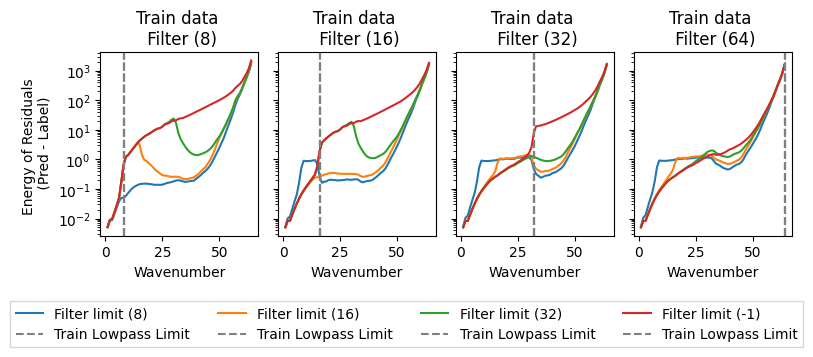

1d energy
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.

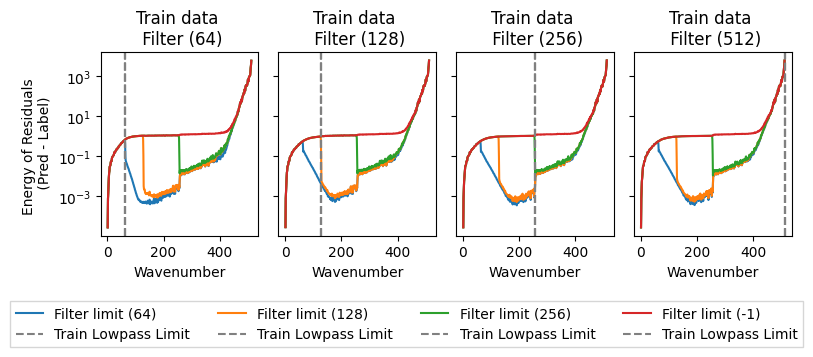

2d energy
Does not exists: /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_42_255_FNO2D_10_1_05_10_single_1_0_0_0//150_ckpt.pth
Does not exists: /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_127_255_FNO2D_10_1_05_10_single_1_0_0_0//150_ckpt.pth
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109


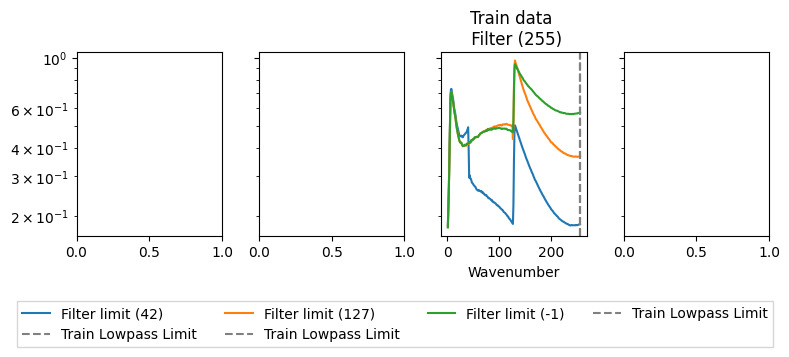

2d energy
Does not exists: /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_32_256_FNO2D_40_4_05_10_single_1_0_0_0//150_ckpt.pth
Does not exists: /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_64_256_FNO2D_40_4_05_10_single_1_0_0_0//150_ckpt.pth
Does not exists: /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_128_256_FNO2D_40_4_05_10_single_1_0_0_0//150_ckpt.pth
Does not exists: /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_single_1_0_0_0//150_ckpt.pth


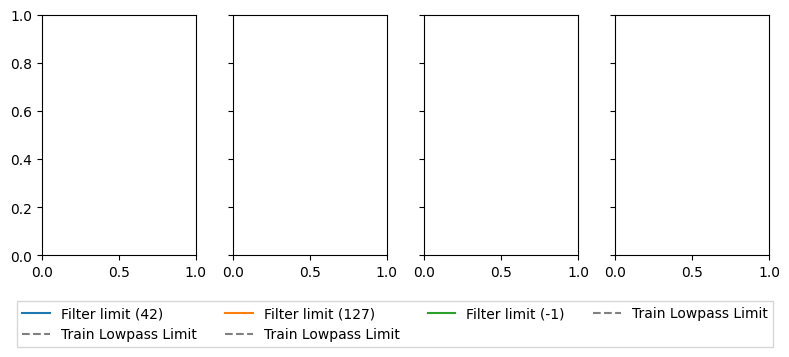

finished_exp=9, total_exp=15, 60.0 %


In [6]:
darcy_forcing_term = 1.0
burger_viscosity = 0.001
seed = 0
total_exp = 0
finished_exp = 0

for dataset_name in [
    'darcy_pdebench',
    'burgers_pdebench',
    'incomp_ns_pdebench',
    'ns_pdebench',
]:
    if 'burgers' in dataset_name:
        print('1d energy')
        energy_curve_func = get_energy_curve_1d
    else:
        print('2d energy')
        energy_curve_func = get_energy_curve
        
    if dataset_name == 'darcy_pdebench':
        img_size = 128
        fixed_lim = 8
        filter_lims = [8, 16, 32, -1]  # -1 finished
        downsample_dims = [16, 32, 64, -1]  # 16 finished

    if dataset_name == 'burgers_pdebench':
        img_size = 1024
        model_name = 'FNO1D'
        fixed_lim = 64
        filter_lims = [64, 128, 256, -1]  # -1 finished
        downsample_dims = [128, 256, 512, -1]  # 128 finished

    if dataset_name == 'incomp_ns_pdebench':
        # TODO(MS): waiting for HP search
        img_size = 510
        fixed_lim = 85 // 2  # half of 85 // 2
        filter_lims = [85 // 2, 255 // 2, -1]  # -1 finished
        downsample_dims = [85, 255, -1]  # 85 finished

    if dataset_name == 'ns_pdebench':
        # TODO(MS): waiting for HP search
        img_size = 512
        fixed_lim = 32
        filter_lims = [32, 64, 128, -1]  # -1 finished
        downsample_dims = [64, 128, 256, -1]  # 64 finished

    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        lr,
        wd,
        pinn_loss_weight,
    ) = get_dataset_info(dataset_name, "mse")
    train_resolutions = [1,0,0,0]
    fig, axes = plt.subplots(
        nrows=1, ncols=4, sharey=True, sharex='col', figsize=(8, 3)
    )
    for epoch in [150]:  # 0, 50, 100, 250,
        for y_idx, max_mode in enumerate([64]):
            for _y_idx, downsample_dim in enumerate([-1]):
                for x_idx, filter_lim in enumerate(filter_lims):
                    if filter_lim == -1 and downsample_dim != -1:
                        continue
                    max_mode = img_size // 2
                    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_{downsample_dim}_{filter_lim}_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{str_from_res(train_resolutions)}'
                    ckpt_dir = ckpt_dir.replace(".","")
                    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                    ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
                    total_exp += 1
                    if not os.path.exists(ckpt_file):
                        print(f'Does not exists: {ckpt_file}')
                        continue
                    finished_exp += 1
                    ckpt_name = f'{ckpt_pth}/train_stats.csv'
                    df = pd.read_csv(ckpt_name)
                    # load model
                    model = get_model(
                        model_name=model_name,
                        out_channels=out_channels,
                        in_channels=in_channels,
                        hidden_channels=32,
                        max_modes=max_mode,
                    ).to(device)
                    ckpt_dict = torch.load(
                        ckpt_file,
                        weights_only=False,
                    )
                    model.load_state_dict(ckpt_dict['model_state_dict'])
    
                    # get data at various sizes
                    for test_filt in filter_lims:
                        dataset = get_dataset(
                            dataset_name=dataset_name,
                            filter_lim=test_filt,
                            img_size='n/a',
                            downsample_dim=-1,
                            train=False,
                            initial_steps=initial_steps,
                            model_name=model_name,
                            darcy_forcing_term=darcy_forcing_term,
                            burger_viscosity=burger_viscosity,
                            batch_size=batch_size,
                            seed=0,
                            resolution_ratios=train_resolutions,
                        )
                        test_loader = DataLoader(dataset, batch_size=1)
                        
                        dataset = get_dataset(
                            dataset_name=dataset_name,
                            filter_lim=-1,
                            img_size='n/a',
                            downsample_dim=-1,
                            train=False,
                            initial_steps=initial_steps,
                            model_name=model_name,
                            darcy_forcing_term=darcy_forcing_term,
                            burger_viscosity=burger_viscosity,
                            batch_size=batch_size,
                            seed=0,
                            resolution_ratios=train_resolutions,
                        )
                        unfilter_test_loader = DataLoader(dataset, batch_size=1)
    
                        # get model preds
                        model_preds_test = get_model_preds(
                            test_loader, model, device, initial_steps
                        )
                        offset = 0
                        if initial_steps == 1:
                            offset = 1
                        labels = torch.concat(
                            [
                                test_loader.dataset[i]['y'][:, initial_steps-offset:, ...]
                                for i in range(len(test_loader))
                            ]
                        )
                        unfilter_labels = torch.concat(
                            [
                                unfilter_test_loader.dataset[i]['y'][:, initial_steps - offset:, ...]
                                for i in range(len(unfilter_test_loader))
                            ]
                        )
                        residuals = model_preds_test - labels.to(device)
                        unfilter_label_spectrum = energy_curve_func(
                            unfilter_labels
                        )
                        residual_spectrum = energy_curve_func(residuals)
    
                        x = np.linspace(
                            1, len(residual_spectrum), len(residual_spectrum)
                        )
                        axes[x_idx].set_yscale('log')
                        axes[x_idx].plot(
                            x,
                            residual_spectrum / unfilter_label_spectrum,
                            label=f'Filter limit ({test_filt})',
                        )
                        f_lim = filter_lim
                        if filter_lim == -1:
                            f_lim = max_mode
                        axes[x_idx].axvline(
                            x=f_lim,
                            color='grey',
                            linestyle='--',
                            label='Train Lowpass Limit',
                        )
                        axes[x_idx].set_title(
                            f'Train data \n Filter ({f_lim})'
                        )
                        axes[x_idx].set_xlabel('Wavenumber')
                        if x_idx == 0:
                            axes[x_idx].set_ylabel(
                                'Energy of Residuals \n (Pred - Label)'
                            )
                        handles, labels = axes[
                            x_idx
                        ].get_legend_handles_labels()
    
        fig.legend(
            handles=handles,
            labels=labels,
            loc='upper center',
            bbox_to_anchor=(0.5, -0.0),
            fancybox=False,
            shadow=False,
            ncol=4,
        )
        plt.tight_layout()
        plt.show()
        # fig.savefig(
        #    f'{FIG_DIR}/varried_downsample_{epoch}_w_max_modes.png',
        #    dpi=300,
        #    bbox_inches='tight',
        # )
print(f'{finished_exp=}, {total_exp=}, {finished_exp / total_exp * 100} %')

2d energy
ckpt_file='/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_16_8_64_FNO2D_1_1_05_1_single_1_0_0_0//150_ckpt.pth'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
ckpt_file='/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_32_8_64_FNO2D_1_1_05_1_single_1_0_0_0//150_ckpt.pth'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_rat

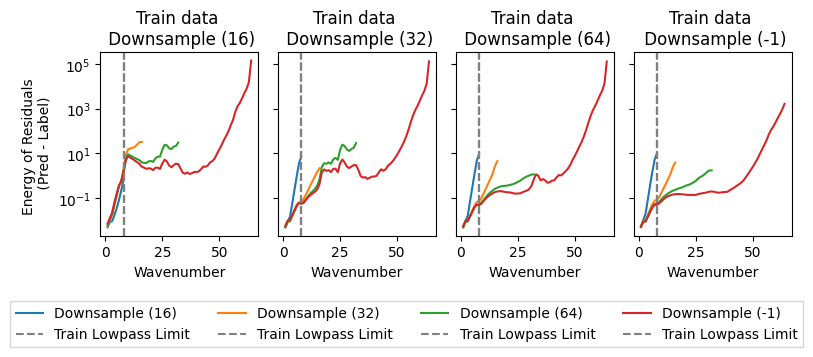

1d energy
ckpt_file='/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_64_burgers_pdebench_128_64_512_FNO1D_10_1_05_10_single_1_0_0_0//150_ckpt.pth'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
ckpt_file='/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_64_burgers_pdebench_256_64_512_FNO1D_10_1_05_10_single_1_0_0_0//150_ckpt.pth'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
re

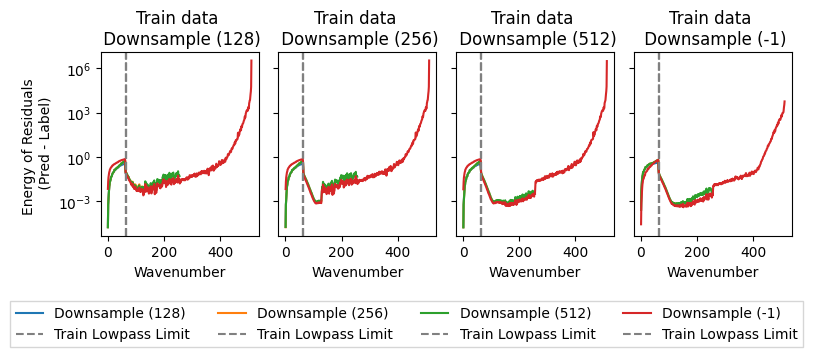

2d energy
Does not exists: /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_85_42_255_FNO2D_10_1_05_10_single_1_0_0_0//150_ckpt.pth
Does not exists: /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_255_42_255_FNO2D_10_1_05_10_single_1_0_0_0//150_ckpt.pth
Does not exists: /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_42_255_FNO2D_10_1_05_10_single_1_0_0_0//150_ckpt.pth


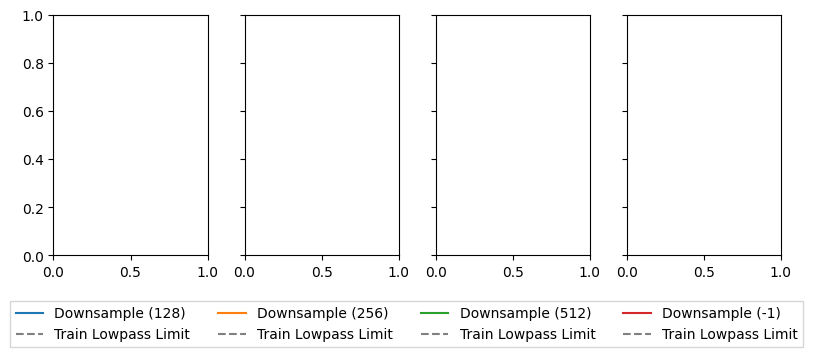

2d energy
Does not exists: /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_64_32_256_FNO2D_40_4_05_10_single_1_0_0_0//150_ckpt.pth
Does not exists: /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_128_32_256_FNO2D_40_4_05_10_single_1_0_0_0//150_ckpt.pth
Does not exists: /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_256_32_256_FNO2D_40_4_05_10_single_1_0_0_0//150_ckpt.pth
Does not exists: /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_32_256_FNO2D_40_4_05_10_single_1_0_0_0//150_ckpt.pth


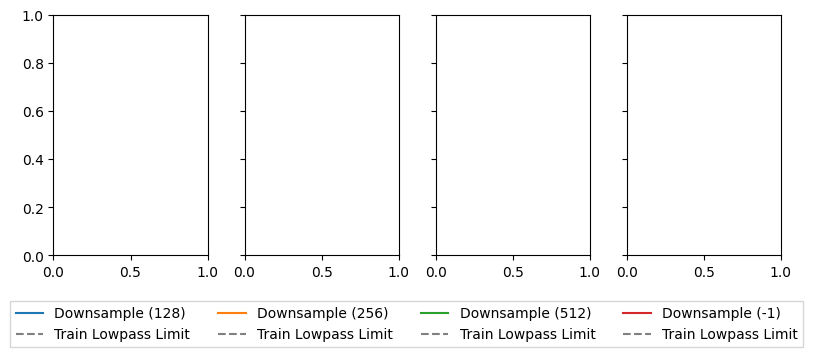

finished_exp=8, total_exp=15, 53.333333333333336 %


In [4]:
darcy_forcing_term = 1.0
burger_viscosity = 0.001
seed = 0
total_exp = 0
finished_exp = 0

for dataset_name in [
    'darcy_pdebench',
    'burgers_pdebench',
    'incomp_ns_pdebench',
    'ns_pdebench',
]:
    if 'burgers' in dataset_name:
        print('1d energy')
        energy_curve_func = get_energy_curve_1d
    else:
        print('2d energy')
        energy_curve_func = get_energy_curve
        
    if dataset_name == 'darcy_pdebench':
        img_size = 128
        fixed_lim = 8
        filter_lims = [8, 16, 32, -1]  # -1 finished
        downsample_dims = [16, 32, 64, -1]  # 16 finished

    if dataset_name == 'burgers_pdebench':
        img_size = 1024
        model_name = 'FNO1D'
        fixed_lim = 64
        filter_lims = [64, 128, 256, -1]  # -1 finished
        downsample_dims = [128, 256, 512, -1]  # 128 finished

    if dataset_name == 'incomp_ns_pdebench':
        # TODO(MS): waiting for HP search
        img_size = 510
        fixed_lim = 85 // 2  # half of 85 // 2
        filter_lims = [85 // 2, 255 // 2, -1]  # -1 finished
        downsample_dims = [85, 255, -1]  # 85 finished

    if dataset_name == 'ns_pdebench':
        # TODO(MS): waiting for HP search
        img_size = 512
        fixed_lim = 32
        filter_lims = [16, 32, 64, -1]  # -1 finished
        downsample_dims = [64, 128, 256, -1]  # 64 finished

    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        lr,
        wd,
        pinn_loss_weight,
    ) = get_dataset_info(dataset_name, "mse")
    train_resolutions = [1,0,0,0]
    fig, axes = plt.subplots(
        nrows=1, ncols=4, sharey=True, sharex='col', figsize=(8, 3)
    )
    for epoch in [150]:  # 0, 50, 100, 250,
        for y_idx, max_mode in enumerate([64]):
            for x_idx, downsample_dim in enumerate(downsample_dims):
                for _y_idx, filter_lim in enumerate([fixed_lim]):
                    if filter_lim == -1 and downsample_dim != -1:
                        continue
                    max_mode = img_size // 2
                    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_{downsample_dim}_{filter_lim}_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{str_from_res(train_resolutions)}'
                    ckpt_dir = ckpt_dir.replace(".","")
                    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                    ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
                    total_exp += 1
                    if not os.path.exists(ckpt_file):
                        print(f'Does not exists: {ckpt_file}')
                        continue
                    finished_exp += 1
                    ckpt_name = f'{ckpt_pth}/train_stats.csv'
                    df = pd.read_csv(ckpt_name)
                    # load model
                    model = get_model(
                        model_name=model_name,
                        out_channels=out_channels,
                        in_channels=in_channels,
                        hidden_channels=32,
                        max_modes=max_mode,
                    ).to(device)
                    # ckpt_dict = load_latest_ckpt(ckpt_pth)
    
                    print(f'{ckpt_file=}')
                    ckpt_dict = torch.load(
                        ckpt_file,
                        weights_only=False,
                    )
                    model.load_state_dict(ckpt_dict['model_state_dict'])
    
                    # get data at various sizes
                    for test_down in downsample_dims:
                        dataset = get_dataset(
                            dataset_name=dataset_name,
                            filter_lim=filter_lim,
                            img_size='n/a',
                            downsample_dim=test_down,
                            train=False,
                            initial_steps=initial_steps,
                            model_name=model_name,
                            darcy_forcing_term=darcy_forcing_term,
                            burger_viscosity=burger_viscosity,
                            batch_size=batch_size,
                            seed=0,
                            resolution_ratios=train_resolutions,
                        )
                        test_loader = DataLoader(dataset, batch_size=1)
                        
                        dataset = get_dataset(
                            dataset_name=dataset_name,
                            filter_lim=-1,
                            img_size='n/a',
                            downsample_dim=test_down,
                            train=False,
                            initial_steps=initial_steps,
                            model_name=model_name,
                            darcy_forcing_term=darcy_forcing_term,
                            burger_viscosity=burger_viscosity,
                            batch_size=batch_size,
                            seed=0,
                            resolution_ratios=train_resolutions,
                        )
                        unfilter_test_loader = DataLoader(dataset, batch_size=1)
    
                        # get model preds
                        model_preds_test = get_model_preds(
                            test_loader, model, device, initial_steps
                        )
                        offset = 0
                        if initial_steps == 1:
                            offset = 1
                        labels = torch.concat(
                                [
                                    test_loader.dataset[i]['y'][:, initial_steps - offset:, ...]
                                    for i in range(len(test_loader))
                                ]
                            )
                        label_spectrum = energy_curve_func( labels)
                        unfilter_labels = torch.concat(
                            [
                                unfilter_test_loader.dataset[i]['y'][:, initial_steps - offset:, ...]
                                for i in range(len(unfilter_test_loader))
                            ]
                        )
                        residuals = model_preds_test - labels.to(device)
                        unfilter_label_spectrum = energy_curve_func(
                            unfilter_labels
                        )
                        residual_spectrum = energy_curve_func(residuals)
    
                        x = np.linspace(
                            1, len(residual_spectrum), len(residual_spectrum)
                        )
                        axes[x_idx].set_yscale('log')
                        axes[x_idx].plot(
                            x,
                            residual_spectrum / unfilter_label_spectrum,
                            label=f'Downsample ({test_down})',
                        )
                        axes[x_idx].axvline(
                            x=filter_lim,
                            color='grey',
                            linestyle='--',
                            label='Train Lowpass Limit',
                        )
                        axes[x_idx].set_title(
                            f'Train data \n Downsample ({downsample_dim})'
                        )
                        axes[x_idx].set_xlabel('Wavenumber')
                        if x_idx == 0:
                            axes[x_idx].set_ylabel(
                                'Energy of Residuals \n (Pred - Label)'
                            )
                        handles, labels = axes[
                            x_idx
                        ].get_legend_handles_labels()
    
        fig.legend(
            handles=handles,
            labels=labels,
            loc='upper center',
            bbox_to_anchor=(0.5, -0.0),
            fancybox=False,
            shadow=False,
            ncol=4,
        )
        plt.tight_layout()
        plt.show()
        # fig.savefig(
        #    f'{FIG_DIR}/varried_downsample_{epoch}_w_max_modes.png',
        #    dpi=300,
        #    bbox_inches='tight',
        # )
print(f'{finished_exp=}, {total_exp=}, {finished_exp / total_exp * 100} %')

# Multi-Res Training

Training curves w/ multi-res test sets

TODO: Plot multi-res spectrum

TODO: REDO ALL BURGERS DUE TO MULTI - RES data bug

Middle plot sweep:
- Story: Middle plot shows fragility
- Add in the residual energy spectrum for each res
- Add in the base energy spectrum for each res
- Add in 7:1:1:1 ratio, add in the 1:0:0:0 ratio

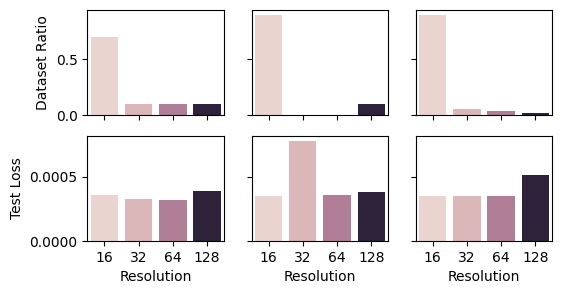

In [52]:
fig, axes = plt.subplots(
    nrows=2, ncols=3, sharey='row', sharex='col', figsize=(6, 3)
)

dataset_name = 'darcy_pdebench'
loss = 'mse'
(
    model_name,
    in_channels,
    out_channels,
    initial_steps,
    loss,
    batch_size,
    lr,
    wd,
    pinn_loss_weight,
) = get_dataset_info(dataset_name, "mse")
#lr = str(lr).replace('.','')
if dataset_name == 'darcy_pdebench':
    img_sizes = [128, 64, 32, 16]
    img_size = 128
    max_mode = img_size // 2


final_ckpts = []

res_ratios = [
    [0.1,0.1,0.1,0.7],
    [0.1,0,0,0.9],
    [0.02,0.03,0.05,0.9],
]
for x_idx, res_ratio in enumerate(res_ratios):
    res_ratio_str = str_from_res(res_ratio)
    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_multi_{res_ratio_str}'
    ckpt_dir = ckpt_dir.replace('.','')
    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
    ckpt_name = f'{ckpt_pth}/train_stats.csv'

    if not os.path.exists(ckpt_name):
        print('does not exist: ', ckpt_dir)
        continue
    df = pd.read_csv(ckpt_name)
    losses = df[df.epoch==150][['test_res_0', 'test_res_1','test_res_2','test_res_3']].values.squeeze().tolist()
    sns.barplot(y=res_ratio, x=img_sizes, ax=axes[0, x_idx], hue=img_sizes)
    sns.barplot(y = losses, x=img_sizes,  ax=axes[1, x_idx], hue=img_sizes)
    axes[0, x_idx].get_legend().remove()
    axes[1, x_idx].get_legend().remove()

    if x_idx == 0:
        axes[0, x_idx].set_ylabel('Dataset Ratio')
        axes[1, x_idx].set_ylabel('Test Loss')

    axes[1, x_idx].set_xlabel("Resolution")
#plt.legend(bbox_to_anchor=(-0.5, -0.5), loc='upper center', ncols=4)

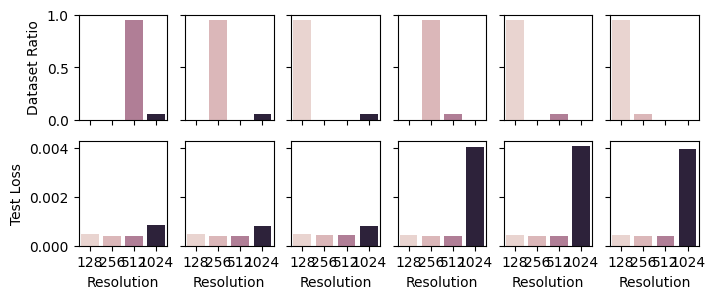

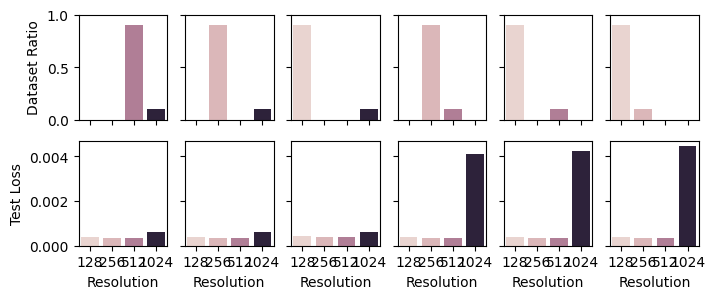

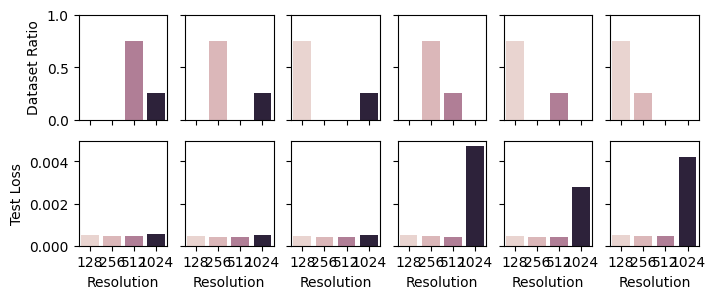

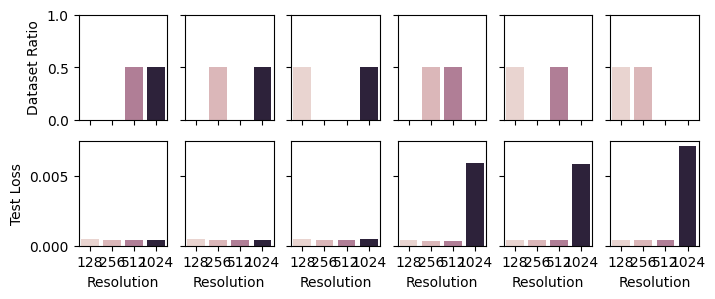

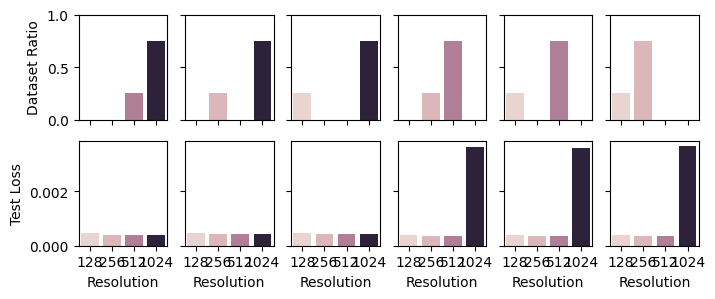

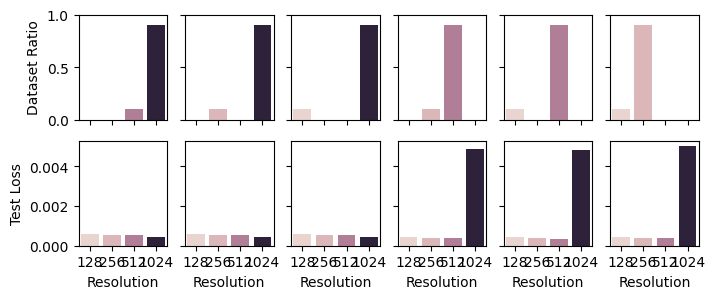

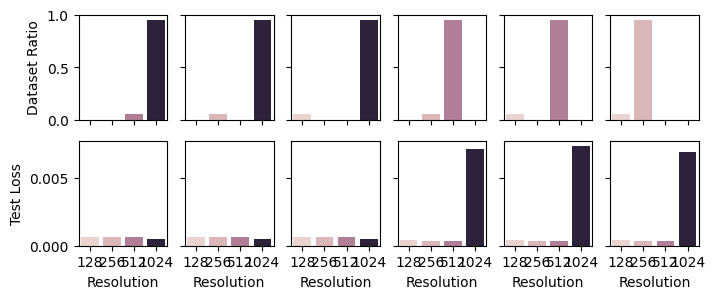

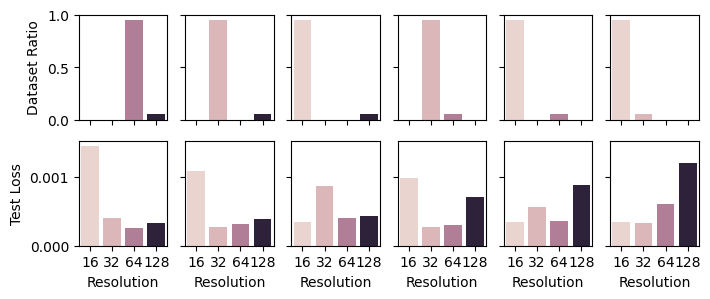

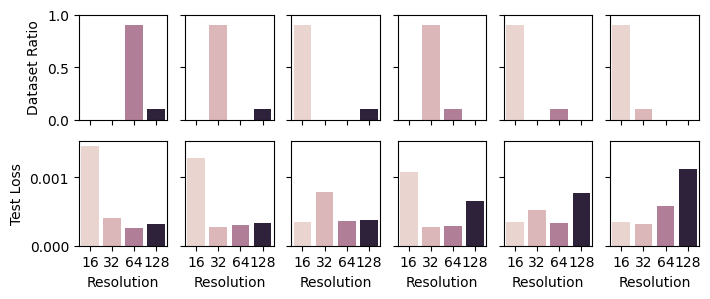

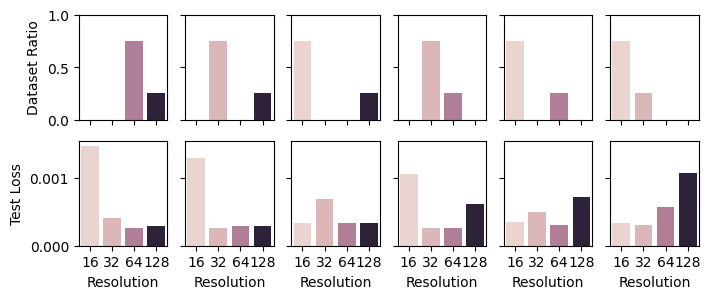

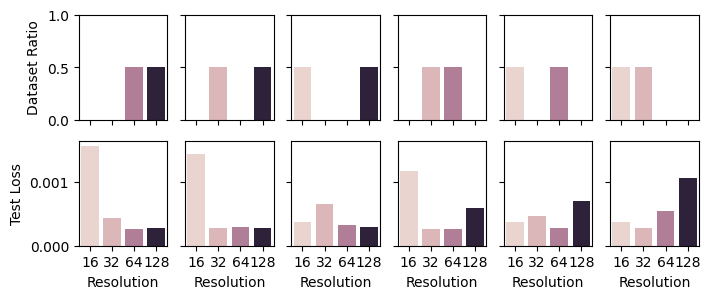

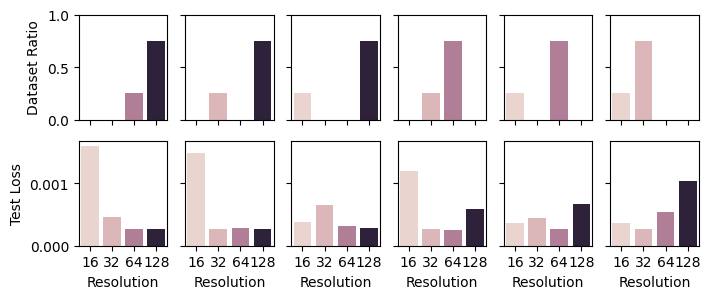

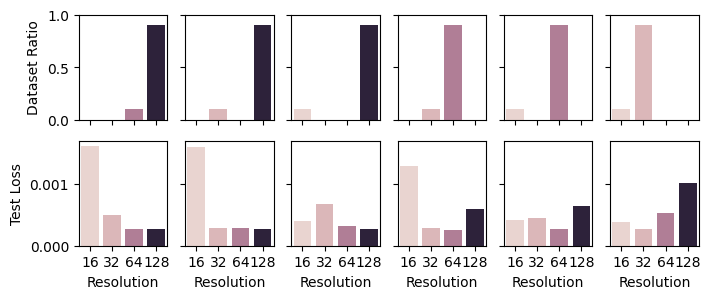

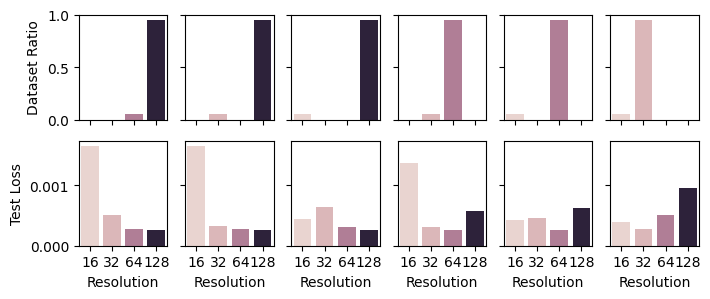

does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_005_095_0_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_005_0_095_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_005_0_0_095/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_0_005_095_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_0_005_0_095/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10

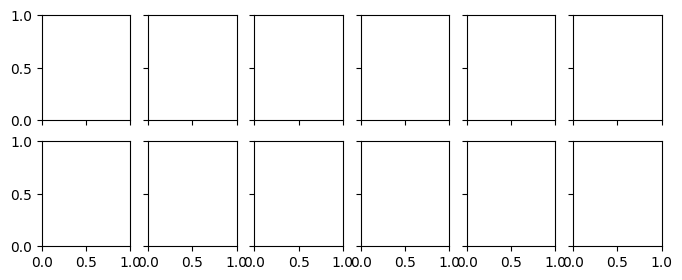

does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_01_09_0_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_01_0_09_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_01_0_0_09/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_0_01_09_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_0_01_0_09/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_0_0

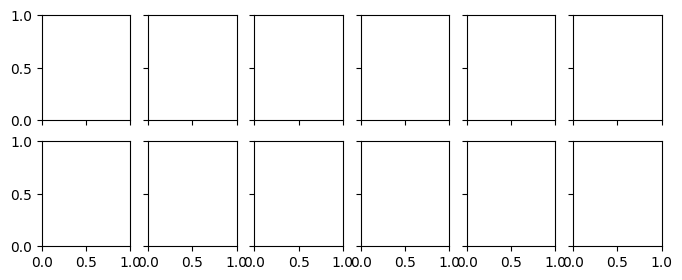

does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_025_075_0_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_025_0_075_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_025_0_0_075/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_0_025_075_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_0_025_0_075/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10

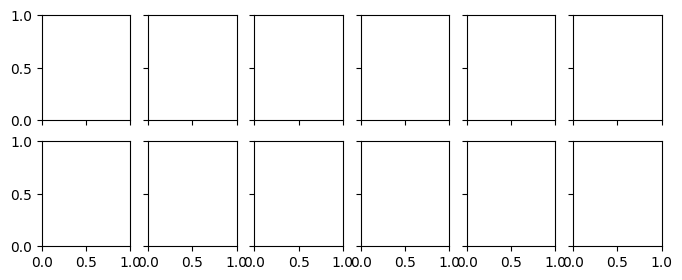

does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_05_05_0_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_05_0_05_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_05_0_0_05/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_0_05_05_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_0_05_0_05/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_0_0

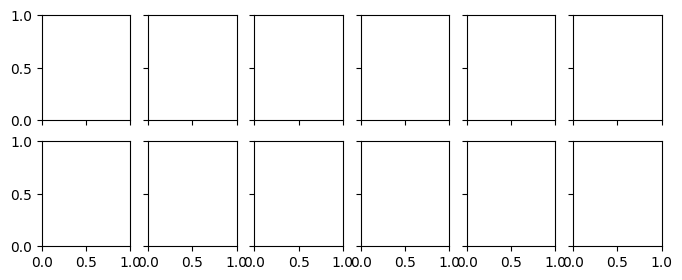

does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_075_025_0_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_075_0_025_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_075_0_0_025/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_0_075_025_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_0_075_0_025/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10

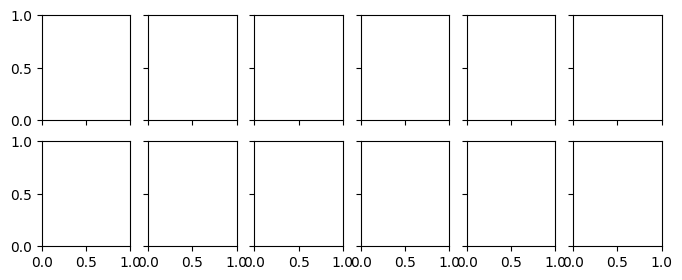

does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_09_01_0_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_09_0_01_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_09_0_0_01/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_0_09_01_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_0_09_0_01/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_0_0

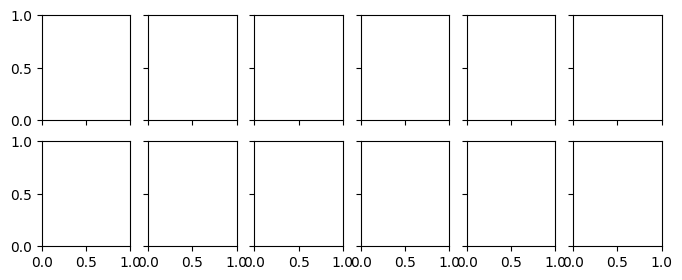

does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_095_005_0_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_095_0_005_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_095_0_0_005/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_0_095_005_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10_multi_0_095_0_005/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_-1_-1_255_FNO2D_10_1_05_10

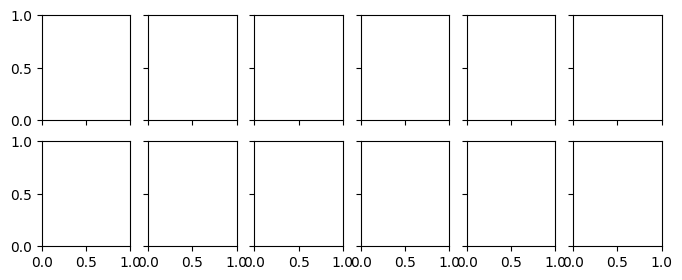

does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_005_095_0_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_005_0_095_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_005_0_0_095/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_0_005_095_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_0_005_0_095/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_0_0_005_095/


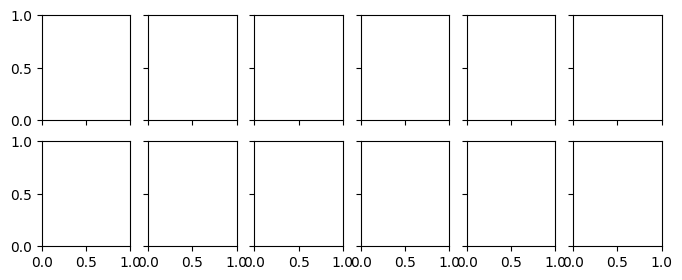

does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_01_09_0_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_01_0_09_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_01_0_0_09/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_0_01_09_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_0_01_0_09/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_0_0_01_09/


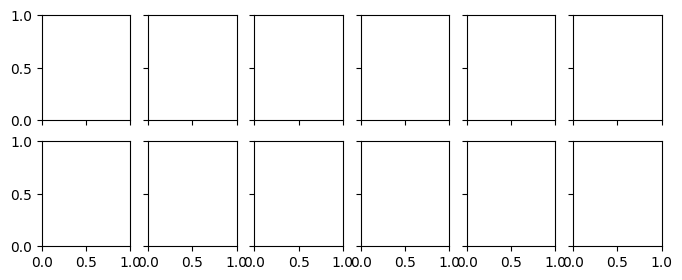

does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_025_075_0_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_025_0_075_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_025_0_0_075/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_0_025_075_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_0_025_0_075/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_0_0_025_075/


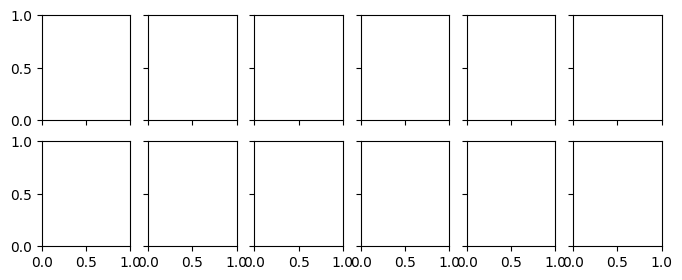

does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_05_05_0_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_05_0_05_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_05_0_0_05/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_0_05_05_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_0_05_0_05/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_0_0_05_05/


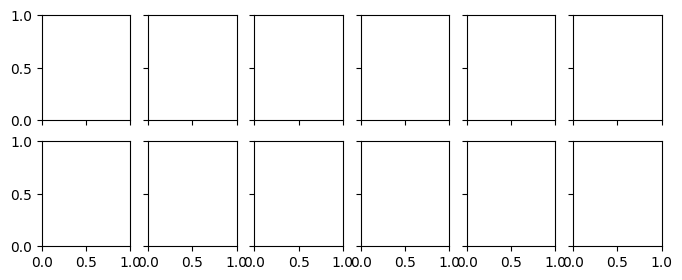

does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_075_025_0_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_075_0_025_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_075_0_0_025/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_0_075_025_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_0_075_0_025/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_0_0_075_025/


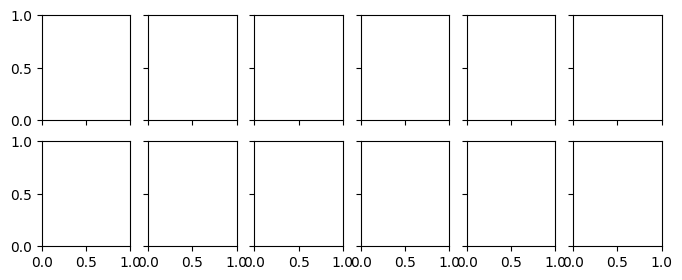

does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_09_01_0_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_09_0_01_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_09_0_0_01/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_0_09_01_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_0_09_0_01/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_0_0_09_01/


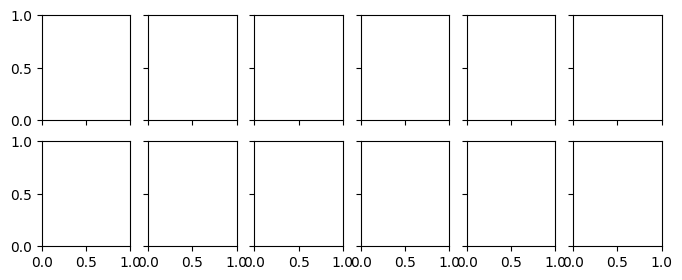

does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_095_005_0_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_095_0_005_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_095_0_0_005/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_0_095_005_0/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_0_095_0_005/
does not exist:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-06_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_multi_0_0_095_005/


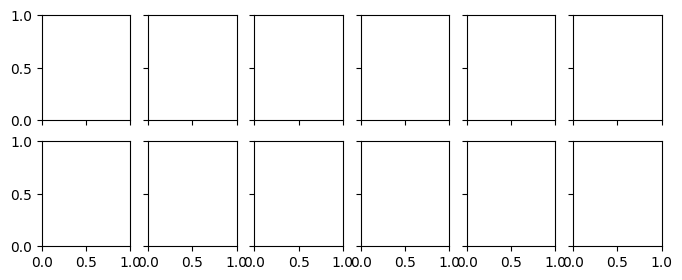

In [8]:
for dataset_name in ['burgers_pdebench','darcy_pdebench', 'incomp_ns_pdebench', 'ns_pdebench']: # , 
    loss = 'mse'
    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        lr,
        wd,
        pinn_loss_weight,
    ) = get_dataset_info(dataset_name, "mse")
    #lr = str(lr).replace('.','')
    if dataset_name == 'darcy_pdebench':
        img_sizes = [128, 64, 32, 16]
        img_size = 128
    if dataset_name == 'burgers_pdebench':
        img_sizes = [1024, 512, 256, 128]
        img_size = 1024
    if dataset_name == 'incomp_ns_pdebench':
        img_sizes = [510, 255, 85, 17]
        img_size = 510
    if dataset_name == 'ns_pdebench':
        img_sizes = [512, 256, 128, 64]
        img_size = 512
        
    max_mode = img_size // 2
    
    
    final_ckpts = []
    
    res_ratios = [
        '[0.1,0.1,0.1,0.7]',
        '[0.1,0,0,0.9]',
        '[0.02,0.03,0.05,0.9]',
    ]
    for _idx, rat in enumerate([0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]):
        fig, axes = plt.subplots(
            nrows=2, ncols=6, sharey='row', sharex='col', figsize=(8, 3)
        )
        for x_idx, (first_idx, second_idx) in enumerate([(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]):
            res_ratio = [0,0,0,0]
            res_ratio[first_idx] = rat
            res_ratio[second_idx] = round(1 - rat,2)
            res_ratio_str = str_from_res(res_ratio) 
            ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_multi_{res_ratio_str}'
            ckpt_dir = ckpt_dir.replace('.','')
            ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
            ckpt_name = f'{ckpt_pth}/train_stats.csv'
            ckpt_file = f'{ckpt_pth}/150_ckpt.pth'
        
            if not os.path.exists(ckpt_file):
                print('does not exist: ', ckpt_pth)
                continue
            df = pd.read_csv(ckpt_name)
            losses = df[df.epoch==150][['test_res_0', 'test_res_1','test_res_2','test_res_3']].values.squeeze().tolist()
            sns.barplot(y=res_ratio, x=img_sizes, ax=axes[0, x_idx], hue=img_sizes)
            sns.barplot(y = losses, x=img_sizes,  ax=axes[1, x_idx], hue=img_sizes)
            axes[0, x_idx].get_legend().remove()
            axes[0,x_idx].set_ylim([0,1])
            axes[1, x_idx].get_legend().remove()
        
            if x_idx == 0:
                axes[0, x_idx].set_ylabel('Dataset Ratio')
                axes[1, x_idx].set_ylabel('Test Loss')
        
            axes[1, x_idx].set_xlabel("Resolution")
        
        plt.show()

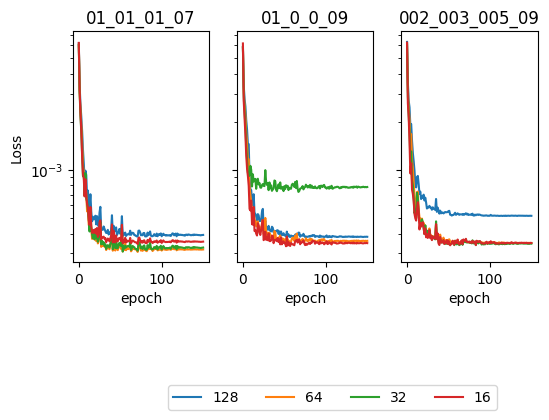

In [70]:
fig, axes = plt.subplots(
    nrows=1, ncols=3, sharey=True, sharex='col', figsize=(6, 3)
)

dataset_name = 'darcy_pdebench'
loss = 'mse'
(
    model_name,
    in_channels,
    out_channels,
    initial_steps,
    loss,
    batch_size,
    lr,
    wd,
    pinn_loss_weight,
) = get_dataset_info(dataset_name, "mse")
#lr = str(lr).replace('.','')
if dataset_name == 'darcy_pdebench':
    img_sizes = [128, 64, 32, 16]
    img_size = 128
    max_mode = img_size // 2


final_ckpts = []

res_ratios = [
    [0.1,0.1,0.1,0.7],
    [0.1,0,0,0.9],
    [0.02,0.03,0.05,0.9],
]
for x_idx, res_ratio in enumerate(res_ratios):
    res_ratio = str_from_res(res_ratio)
    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_multi_{res_ratio}'
    ckpt_dir = ckpt_dir.replace('.','')
    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
    ckpt_name = f'{ckpt_pth}/train_stats.csv'

    if not os.path.exists(ckpt_name):
        print('does not exist: ', ckpt_dir)
        continue
    df = pd.read_csv(ckpt_name)
    df['res_ratio'] = res_ratio
    final_ckpts.append(df[df.epoch == 150])
    for res in range(4):
        ylabel = f'test_res_{res}'
        sns.lineplot(
            df,
            x='epoch',
            y=ylabel,
            label=f'{img_sizes[res]}',
            ax=axes[x_idx],
        )
        axes[x_idx].get_legend().remove()
        axes[x_idx].set_yscale('log')
        axes[x_idx].set_title(res_ratio)
        axes[x_idx].set_ylabel('Loss')

plt.legend(bbox_to_anchor=(-0.5, -0.5), loc='upper center', ncols=4)

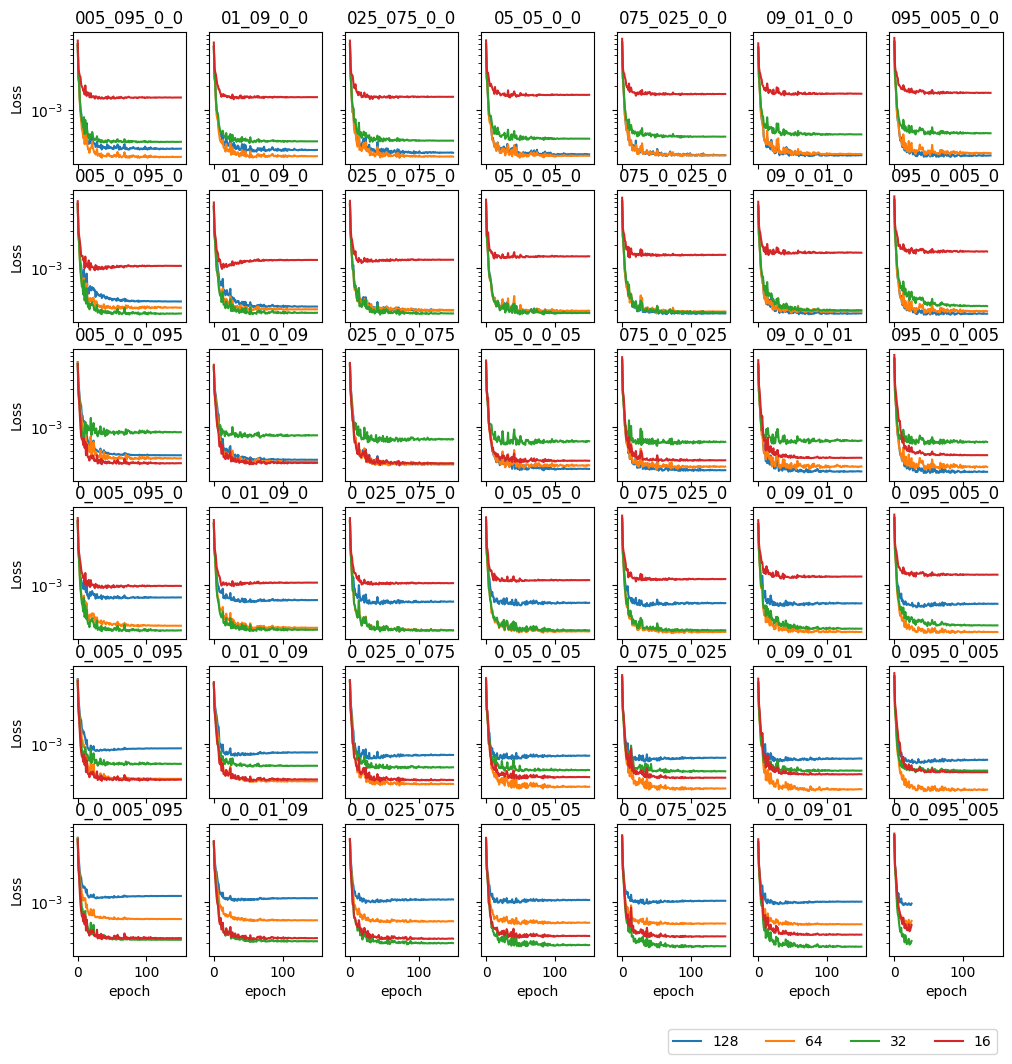

In [72]:
fig, axes = plt.subplots(
    nrows=6, ncols=7, sharey=True, sharex='col', figsize=(12, 12)
)

dataset_name = 'darcy_pdebench'
loss = 'mse'
(
    model_name,
    in_channels,
    out_channels,
    initial_steps,
    loss,
    batch_size,
    lr,
    wd,
    pinn_loss_weight,
) = get_dataset_info(dataset_name, "mse")
#lr = str(lr).replace('.','')
if dataset_name == 'darcy_pdebench':
    img_sizes = [128, 64, 32, 16]
    img_size = 128
    max_mode = img_size // 2


final_ckpts = []

res_ratios = [
    '[0.1,0.1,0.1,0.7]',
    '[0.1,0,0,0.9]',
    '[0.02,0.03,0.05,0.9]',
]
for x_idx, rat in enumerate([0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]):
    for y_idx, (first_idx, second_idx) in enumerate([(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]):
        ratio = [0,0,0,0]
        ratio[first_idx] = rat
        ratio[second_idx] = round(1 - rat,2)
        res_ratio = str_from_res(ratio) #str(ratio).replace(" ","")
        ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_multi_{res_ratio}'
        ckpt_dir = ckpt_dir.replace('.','')
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
        ckpt_name = f'{ckpt_pth}/train_stats.csv'
    
        if not os.path.exists(ckpt_name):
            print('does not exist: ', ckpt_dir)
            continue
        df = pd.read_csv(ckpt_name)
        df['res_ratio'] = res_ratio
        final_ckpts.append(df[df.epoch == 150])
        for res in range(4):
            ylabel = f'test_res_{res}'
            sns.lineplot(
                df,
                x='epoch',
                y=ylabel,
                label=f'{img_sizes[res]}',
                ax=axes[y_idx, x_idx],
            )
            axes[y_idx, x_idx].get_legend().remove()
            axes[y_idx, x_idx].set_yscale('log')
            axes[y_idx, x_idx].set_title(res_ratio)
            axes[y_idx, x_idx].set_ylabel('Loss')

plt.legend(bbox_to_anchor=(-0.5, -0.5), loc='upper center', ncols=4)

In [15]:
final_ckpt = pd.concat(final_ckpts)
final_ckpt['avg'] = final_ckpt[
    ['test_res_0', 'test_res_1', 'test_res_2', 'test_res_3']
].mean(axis=1)
final_ckpt

,epoch,train_loss,train_time,test_res_0,test_res_1,test_res_2,test_res_3,res_ratio,avg
150,150,0.000288,1.670186,0.000392,0.000318,0.000327,0.000356,"[01,01,01,07]",0.000348
150,150,0.000285,1.745384,0.000381,0.000360,0.000781,0.000348,"[01,0,0,09]",0.000468
150,150,0.000286,0.912009,0.000516,0.000349,0.000346,0.000349,"[002,003,005,09]",0.000390


# Generalization Across Turbulence Scales

NS trained at low turbulence, evaluated at high-turbulence

# OLD FIGS

/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


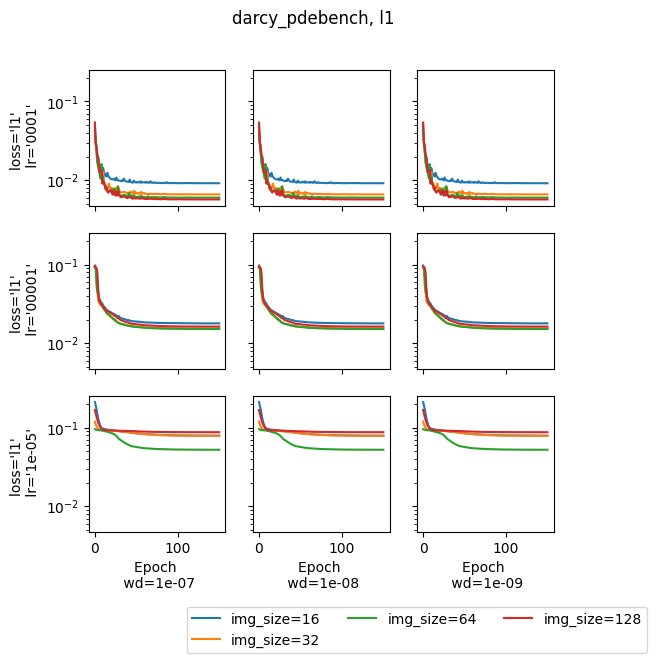

/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


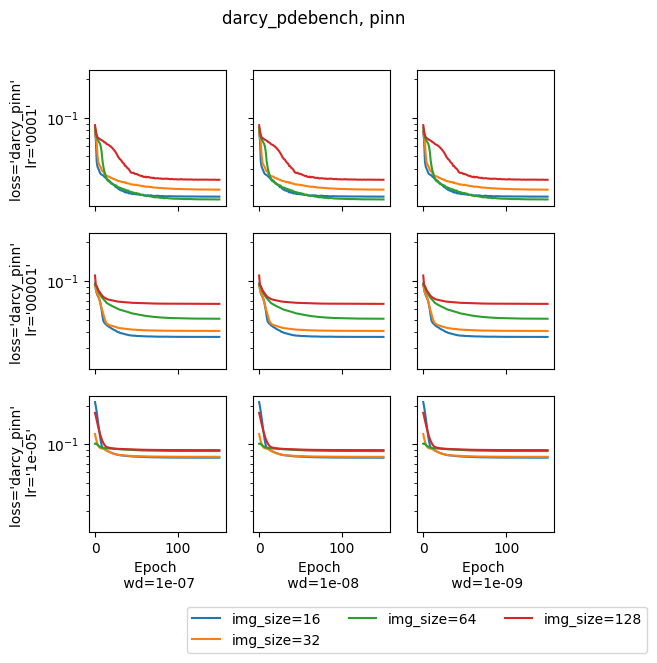

/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


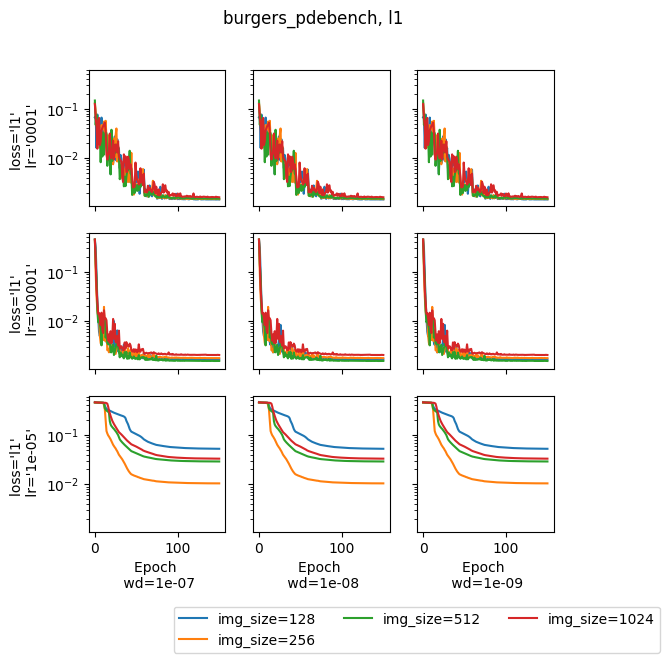

/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


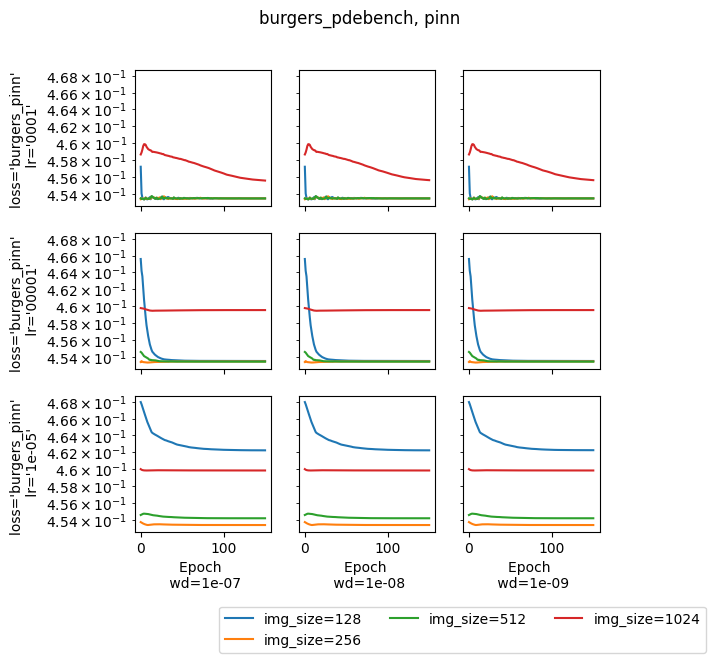

does not exist:  0001_1e-07_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  0001_1e-08_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  0001_1e-09_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-07_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-08_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-09_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-07_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-08_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-09_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10


/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


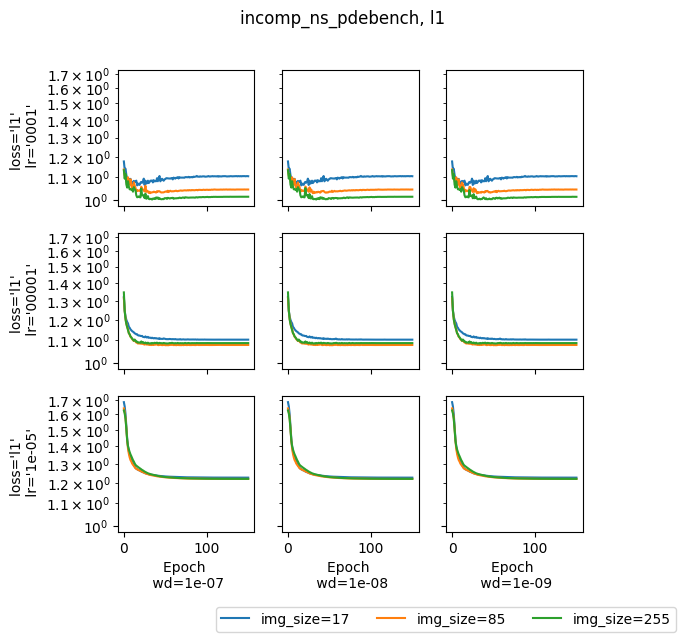

does not exist:  0001_1e-07_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  0001_1e-08_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  0001_1e-09_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-07_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-08_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-09_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-07_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-08_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-09_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10


/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


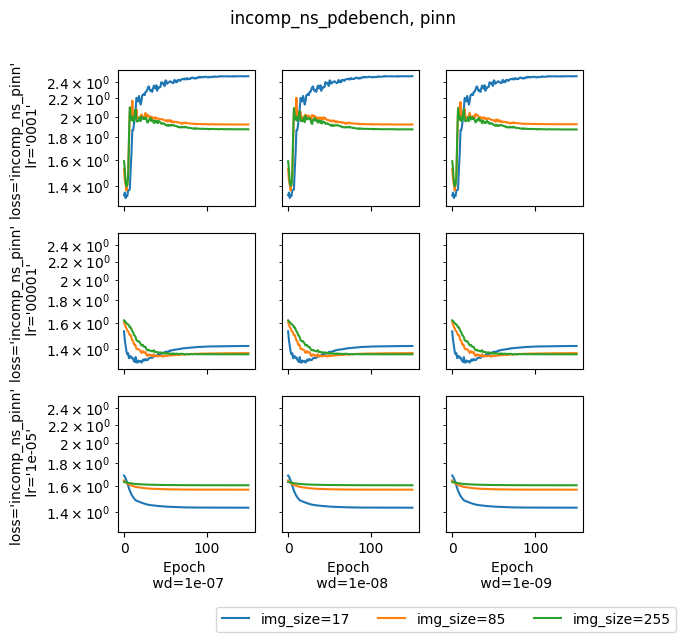

finished_exp=198, total_exp=216, 0.9166666666666666 %


In [3]:
# Check if all experiments have finished
total_exp = 0
finished_exp = 0
for dataset_name in [
    'darcy_pdebench',
    'burgers_pdebench',
    'incomp_ns_pdebench',
]:
    model_name = 'FNO2D'
    in_channels = 10
    initial_steps = 10

    if dataset_name == 'darcy_pdebench':
        img_sizes = [16, 32, 64, 128]
        pinn_loss_name = 'darcy_pinn'
        batch_size = 128
        in_channels = 1
        initial_steps = 1

    if dataset_name == 'burgers_pdebench':
        img_sizes = [128, 256, 512, 1024]
        pinn_loss_name = 'burgers_pinn'
        batch_size = 64
        model_name = 'FNO1D'

    if dataset_name == 'incomp_ns_pdebench':
        img_sizes = [17, 85, 255, 510]
        pinn_loss_name = 'incomp_ns_pinn'
        batch_size = 4

    for loss_type in ['l1', 'pinn']:
        loss = 'l1'
        if loss_type == 'pinn':
            loss = pinn_loss_name
        fig, axes = plt.subplots(
            nrows=3, ncols=3, sharey=True, sharex='col', figsize=(6, 6)
        )
        for y_idx, lr in enumerate(['0001', '00001', '1e-05']):
            for x_idx, wd in enumerate([1e-07, 1e-08, 1e-09]):
                for color_idx, img_size in enumerate(img_sizes):
                    max_mode = img_size // 2
                    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{img_size}_{max_mode}_{model_name}_{in_channels}_{initial_steps}'
                    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                    ckpt_name = f'{ckpt_pth}/train_stats.csv'
                    total_exp += 1
                    if not os.path.exists(ckpt_name):
                        print('does not exist: ', ckpt_dir)
                        continue
                    df = pd.read_csv(ckpt_name)
                    for ylabel in [
                        #'train_loss',
                        'test',
                    ]:
                        if 150 in df['epoch']:
                            finished_exp += 1
                        sns.lineplot(
                            df,
                            x='epoch',
                            y=ylabel,
                            label=f'{img_size=}',
                            ax=axes[y_idx, x_idx],
                        )
                        axes[y_idx, x_idx].get_legend().remove()
                        axes[y_idx, x_idx].set_yscale('log')

                if y_idx == 2:
                    axes[y_idx, x_idx].set_xlabel(f'Epoch \n {wd=}')
                if x_idx == 0:
                    axes[y_idx, x_idx].set_ylabel(f'{loss=} \n {lr=}')

        plt.legend(bbox_to_anchor=(0, -0.5), loc='upper center', ncols=3)
        plt.tight_layout()
        fig.suptitle(f'{dataset_name}, {loss_type}')
        plt.show()
print(f'{finished_exp=}, {total_exp=}, {finished_exp / total_exp} %')

# (BE CAREFUL W/ this is could override things) Recover stats

In [19]:
from operator_aliasing.train.train import test_model


def recompute_train_test_stats(
    dataset_name,
    filter_lim,
    downsample_dim,
    initial_steps,
    model_name,
    seed,
    batch_size,
    train_resolutions,
    in_channels,
    out_channels,
    max_mode,
    pinn_loss_weight,
):
    stats = pd.DataFrame(columns=['epoch', 'train_loss', 'test', 'train_time'])
    darcy_forcing_term = 1.0
    burger_viscosity = 0.001
    # load relavent dataset
    train_loader, test_loaders = get_data(
        dataset_name=dataset_name,
        filter_lim=filter_lim,
        img_size='n/a',
        downsample_dim=downsample_dim,
        train=True,
        initial_steps=initial_steps,
        model_name=model_name,
        darcy_forcing_term=darcy_forcing_term,
        burger_viscosity=burger_viscosity,
        seed=seed,
        batch_size=batch_size,
        resolution_ratios=eval(train_resolutions),
        test_res='single',
    )

    # train_resolutions =
    # iterate thought all ckpts
    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{train_resolutions}'
    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
    model = get_model(
        model_name=model_name,
        max_modes=max_mode,
        hidden_channels=32,
        in_channels=in_channels,
        out_channels=out_channels,
    ).to(device)

    print(ckpt_dir)
    for epoch in range(0, 155, 5):
        ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
        if not os.path.exists(ckpt_file):
            return
        ckpt_dict = torch.load(
            ckpt_file,
            weights_only=False,
        )
        model.load_state_dict(ckpt_dict['model_state_dict'])
        model = model.to(device)
        model = model.eval()

        # compute train/test loss
        train_loss = test_model(
            model,
            {'train': train_loader},
            device,
            initial_steps,
        )
        test_loss = test_model(
            model,
            test_loaders,
            device,
            initial_steps,
        )

        stats.loc[len(stats)] = [
            epoch,
            train_loss['train'],
            test_loss['test'],
            None,
        ]

    print(stats)
    stats.to_csv(f'{ckpt_pth}/train_stats.csv', index=False)
    return

In [8]:
# Check if all experiments have finished
total_exp = 0
finished_exp = 0
seed = 0
learning_rates = {'001': 1e-2, '0001': 1e-3, '00001': 1e-4, '1e-05': 1e-5}
pinn_weights = {'05': 0.5, '025': 0.25, '01': 0.1}
summary_stats = pd.DataFrame(
    columns=['data', 'loss', 'lr', 'wd', 'pinn_loss_weight', 'test']
)
for dataset_name in [
    #'darcy_pdebench',
    'burgers_pdebench',
    #'incomp_ns_pdebench',
    #'ns_pdebench',
]:
    model_name = 'FNO2D'
    in_channels = 10
    out_channels = 1
    initial_steps = 10
    # if dataset_name == 'incomp_ns_pdebench':

    # incomp_ns args
    img_size = 255
    pinn_loss_name = 'incomp_ns_pinn'
    batch_size = 4

    if dataset_name == 'ns_pdebench':
        img_size = 256
        pinn_loss_name = 'n/a'
        batch_size = 4
        # num time steps * channels:
        in_channels = 40
        # num channels:
        out_channels = 4

    if dataset_name == 'darcy_pdebench':
        img_size = 64
        pinn_loss_name = 'darcy_pinn'
        batch_size = 128
        in_channels = 1
        initial_steps = 1

    if dataset_name == 'burgers_pdebench':
        img_size = 512
        pinn_loss_name = 'burgers_pinn'
        batch_size = 64
        model_name = 'FNO1D'

    for loss_type in ['mse', 'pinn']:
        loss = loss_type
        if loss_type == 'pinn':
            loss = pinn_loss_name
        if loss == 'n/a':
            continue
        for y_idx, lr in enumerate(['001', '0001', '00001', '1e-05']):
            for x_idx, wd in enumerate([1e-05, 1e-06, 1e-07]):
                pinn_loss_weights = ['05']
                if 'pinn' in loss_type:
                    pinn_loss_weights += ['025', '01']
                for pinn_loss_weight in pinn_loss_weights:
                    max_mode = img_size // 2

                # recompute_train_test_stats(dataset_name, -1, -1, initial_steps, model_name, seed, batch_size, '[0,1,0,0]', in_channels, out_channels, max_mode, pinn_loss_weight)